In [1]:
import numpy as np
import matplotlib.pyplot as plt
import natsort, glob, h5py
from scipy.optimize import curve_fit
import scipy.signal

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
# changing the display so that the cells fill the whole window

In [3]:
def gauss_fun(x, A, mu, sig):
    return A * np.exp( -(x-mu)**2/(2*sig**2) )

def lin_fun(x, m, x1):
    return m*(x-x1)

In [4]:
def rebin_histogram(bins, counts, new_bin_size):
    """Rebin a histogram to a new bin size.
    Parameters:
        bins (np.ndarray): The bin edges of the histogram.
        counts (np.ndarray): The number of counts in each bin.
        new_bin_size (float): The size of the new bins.
    Returns:
        np.ndarray: The new bin edges.
        np.ndarray: The new bin counts.
    """
    # Find the new number of bins
    new_nbins = int((bins[-1] - bins[0]) / new_bin_size)
    # Create the new bin edges
    new_bins = np.linspace(bins[0], bins[-1], new_nbins + 1)
    # Digitize the original bins into the new bins
    digitized_bins = np.digitize(bins, new_bins)
    # Calculate the new counts
    new_counts = np.array([counts[digitized_bins == i].sum() for i in range(1, new_nbins + 1)])

    new_centers = new_bins[:-1] + np.diff(new_bins)/2
    return new_centers, new_counts

In [5]:
def load_directory(path, file_types='All'):
    # getting files from a certain directory and selecting the data type such as source and wavelength
    # sourting them into a dictionary labeled by the file type
    files = {}
    
    file_list = natsort.realsorted(glob.glob(path + "mca_*.h5"))[::-1] # sorting all of the files in the given directory
    print('Number of files found: ', len(file_list))
    for file in file_list:
        file_parts = file.split("_")
        try:
            file_wavelength = float(file_parts[-2]) # get wavelength from filename
        except ValueError:
            file_wavelength = file_parts[-2] # leaving tag as a string for source data
        if file_types == 'All': # loading all file types
            if file_wavelength not in files: # starting the dictionary of files according to type
                files[file_wavelength] = [file]
            else:
                files[file_wavelength].append(file)
    
        elif str(file_wavelength) in str(file_types): # loading only the specified file types
            if file_wavelength not in files: # starting the dictionary of files according to type
                files[file_wavelength] = [file]
            else:
                files[file_wavelength].append(file)
        else:
            pass
    
    if file_types == 'All': # printing the number of files in the directory
        print('Number of files: ', len(file_list))
    else:
        length = np.sum([len(each) for each in files.values()]) # getting the number of files of a specified type
        print('Number of files: ', length)
    
    return files

In [6]:
def peak_fit_srs10(x_data, y_data, voltage, min_distance=20, max_peaks=5, min_thresh=10, peak_range=500):
    # Find the peaks in the spectrum using the find_peaks function from scipy.signal
    
    peaks_index, _ = scipy.signal.find_peaks(y_data, distance=min_distance)
    
    # Fit each peak with a Gaussian function using the curve_fit function from scipy
    gain_info = [] # parameters to fit the gain
    peak_params = [] # parameters to plot the gaussian
    peak_number = 1 # corresponds to single photoelectron peak
    peaks = [] # list of where all the peaks are that are used in the fits
    peak_cuts = []
    for peak in peaks_index:
        if peak_number > max_peaks: # stopping the loop after we have reached the max number of peaks
            break

        if peak < min_thresh:
            continue
        
        peaks.append(np.array([x_data[peak], y_data[peak]]))
        
        # initial guess for the Gaussian parameters
        amplitude_guess = y_data[peak]
        mean_guess = x_data[peak]
        standard_deviation_guess = 10
        initial_guess = [amplitude_guess, mean_guess, standard_deviation_guess]
        
        # cutting data around each peak
        if peak_number == 1: # trying to not include the pedestal for the first peak
            cut = (x_data < (x_data[peak] + peak_range)) & (x_data > (x_data[peak] - 40))
        else:
            cut = (x_data < (x_data[peak] + peak_range)) & (x_data > (x_data[peak] - peak_range))
        peak_x = x_data[cut] # x values of peak for fitting
        peak_y = y_data[cut] # y values of peak for fitting
        peak_cuts.append([peak_x, peak_y])
        
#         plt.yscale('log')
#         plt.plot(x_data[cut], y_data[cut], alpha=0.5)
        
        # Perform the curve fitting
        try:
            # trying to fit the peaks
            params, params_covariance = curve_fit(gauss_fun, peak_x, peak_y, p0=initial_guess)
            # params are returned as amplitude, mean, std dev
            print('Guess: ', initial_guess)
            print('Params: ', params)
            peak_params.append(params)
            gain_info.append([peak_number, params[1], np.sqrt(params_covariance[1,1])]) # peak number, mean, and covariance
        except RuntimeError as r:
            # if curve fit doesn't work then we will just use the peak amplitude and center that find_peaks found
            print('fit failed')
            params = initial_guess
            peak_params.append(initial_guess)
            gain_info.append([peak, mean_guess, np.nan])
#             xx = np.linspace( x_data[peak] - 2*standard_deviation_guess, x_data[peak] + 2*standard_deviation_guess, 100 )
        
        peak_number += 1 # (goes to n*spe until it reaches max_peak)
        
    plt.show()
    return np.array(peak_params), np.array(gain_info), np.array(peaks), peak_cuts

In [7]:
def gain_fit(pe_locations):
    # fitting a line of the peak centers and heights to get the slope (gain) 
    fpts = ~np.isnan(pe_locations[:,1])
    if(np.sum(fpts) < 3):
        return
    # fitting the peak locations to a line to find the gain (slope)
    gain_bp, gain_bc = curve_fit(lin_fun, pe_locations[fpts, 0], pe_locations[fpts, 1])

    x = pe_locations[fpts, 0]
    
    return x, gain_bp, gain_bc

def find_bv(g_vs_v, wavelength):
    # finding the breakdown voltage using fitted gain data of a certain wavelength (310, 405, or source)
    data_to_use = np.asarray(g_vs_v[wavelength])
    
    # fitting the curve 
    bv_params, bv_cov = curve_fit(lin_fun, data_to_use[:, 0], data_to_use[:, 1], sigma=data_to_use[:, 2])
    
    return bv_params, bv_cov

In [8]:
def plot_fit_gain_dc(file, peak_dist, SRS_gain, binsize):
    # doing the gain calculations and plotting the results (hopefully store this in a separate script at some point)
    gain_vs_volts = {}
    print("Working on file %s"%(file))
    
    file_parts = file.split("_")
    file_volts = float( file_parts[-3][:-2] ) # get voltage from filename
    try:
        file_wavelength = float(file_parts[-2]) # get wavelength from filename
    except ValueError:
        file_wavelength = file_parts[-2] # leaving tag as a string for source data
    
    if (SRS_gain == 10):
    # setting the peak range for low gain data
        if file_volts < 31.5 and file_volts >=30.5:
            peak_range = 45 # picking a smaller range of values to fit over for the lower OV files
        elif file_volts < 30.5:
            print('low voltage range')
            peak_range = 25
        else:
            peak_range = 55 
    
    # extracting the data from the files
    f = h5py.File(file, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys():
        mca_hist = np.array(ch2.get(key))
    bin_num = np.arange(len(mca_hist))
    b, c = rebin_histogram(bin_num, mca_hist, binsize) ## might add a conditional binsize once we figure out what that needs to be for each thing
    
    # getting the peak and fit info
    if file_wavelength == 'source':
        peak_info, pe_locs, peaks, data_for_fits = peak_fit_srs10(b, c, file_volts, min_distance=peak_dist*25/100, min_thresh=17, peak_range=peak_range)
    elif file_wavelength == 405.0:
        peak_info, pe_locs, peaks, data_for_fits = peak_fit_srs10(b, c, file_volts, min_distance=peak_dist*25/100, min_thresh=17, peak_range=peak_range, max_peaks=4)
    elif file_wavelength == 310.0:
        peak_info, pe_locs, peaks, data_for_fits = peak_fit_srs10(b, c, file_volts, min_distance=peak_dist*25/100, min_thresh=17, peak_range=peak_range, max_peaks=3)
    
    
    # starting the plots
    plt.figure(figsize=(18,6))
    
    # calculating and plotting the gain 
    plt.subplot(1,2,2)
    plt.errorbar( pe_locs[:,0], pe_locs[:,1], yerr=pe_locs[:,2], fmt='ko' )

    xx, gain_params, gain_cov = gain_fit(pe_locs)
    gain_error = np.sqrt(np.diag(gain_cov))[0]
    plt.plot( xx, lin_fun(xx, *gain_params), 'r', label=r'Gain: %.2f $\pm$ %.2f'%(gain_params[0], gain_error))  #(str(np.round(popt_temp[0],2)))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_temp))[0],2))+' ADC/PE'
    plt.legend()
    

    
    # plotting the peaks
    plt.subplot(1,2,1)
    plt.grid()
    plt.ylim(0.1, 8000)
    plt.yscale('log')
#     plt.ylim(0.1, np.max(mca_hist)*2)
    plt.xlim(0.1, 1000)
#     plt.xticks(np.arange(0, 9, 1))
    
    plt.plot(b, c, 'k')
    plt.plot(peaks[:,0], peaks[:,1], 'o', color='r')
    for fit_params, data_peaks in zip(peak_info, data_for_fits):
        plt.plot(b, gauss_fun(b, *fit_params))
        plt.plot(data_peaks[0], data_peaks[1])
    plt.show()
    
    return b, c, gain_params[0], gain_error, gain_params[1]

In [9]:
# getting the data that we need
path_10 = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/'
files_10 = load_directory(path_10)
SRS_gain_10 = 10 # gain on the SRS bandpass filter
# peak_threshold = 700 # upper bound of pedestal
# breakdown = 27.4 # breakdown voltage of the SiPM
pedestal_10 = 275 # center of noise pedestal peak

Number of files found:  104
Number of files:  104


Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_34.h5
Guess:  [1570, 205.0375457875458, 10]
Params:  [1515.66283453  204.43553119   24.07303356]
Guess:  [723, 295.0540293040293, 10]
Params:  [640.22310449 297.91657661  30.84700752]
Guess:  [398, 405.0741758241758, 10]
Params:  [377.53631454 397.28494787  29.46944338]
Guess:  [233, 485.0888278388278, 10]
Params:  [215.52667942 489.99061937  37.32235948]
Guess:  [154, 585.1071428571429, 10]
Params:  [147.43912246 590.14144816  33.5986548 ]


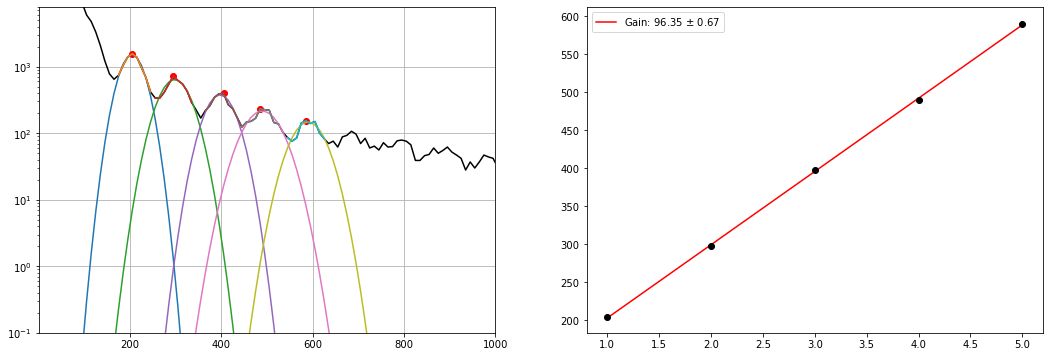

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_33.h5
Guess:  [1547, 205.0375457875458, 10]
Params:  [1473.75713094  203.4066389    24.98635408]
Guess:  [709, 295.0540293040293, 10]
Params:  [674.71434451 297.13538355  29.49656732]
Guess:  [378, 395.0723443223443, 10]
Params:  [377.31495208 394.01725139  30.37515925]
Guess:  [228, 495.09065934065933, 10]
Params:  [224.84252581 491.68036795  32.85404412]
Guess:  [153, 595.1089743589744, 10]
Params:  [151.8370839  591.02843387  32.98877767]


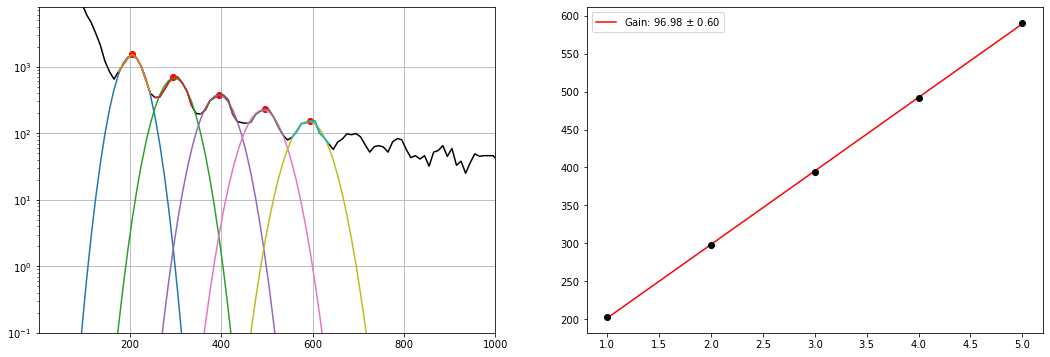

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_32.h5
Guess:  [1403, 205.0375457875458, 10]
Params:  [1350.54733888  204.13344323   26.14277466]
Guess:  [641, 305.0558608058608, 10]
Params:  [628.56196224 299.38111562  29.13377892]
Guess:  [375, 395.0723443223443, 10]
Params:  [365.79642303 396.41967127  29.98969028]
Guess:  [220, 505.09249084249086, 10]
Params:  [208.2759198  493.31078575  36.36976153]
Guess:  [158, 585.1071428571429, 10]
Params:  [140.32947672 590.21542486  34.98459153]


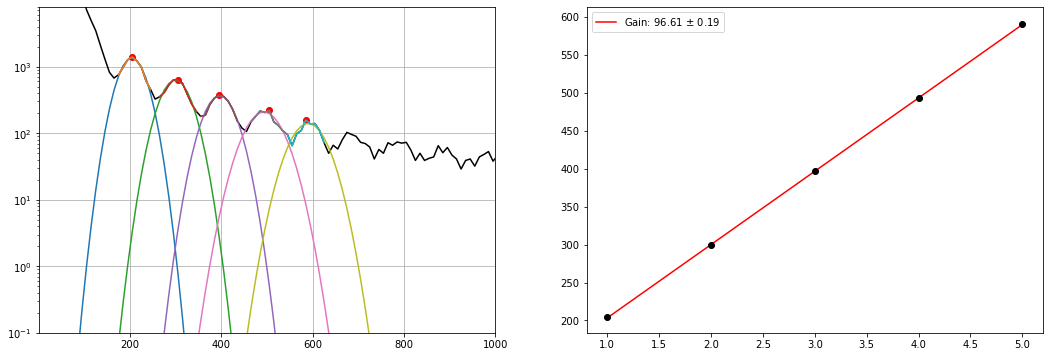

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_31.h5
Guess:  [1540, 205.0375457875458, 10]
Params:  [1491.4759263   204.43669575   23.60254306]
Guess:  [670, 295.0540293040293, 10]
Params:  [646.36114637 297.70010256  30.92242376]
Guess:  [363, 395.0723443223443, 10]
Params:  [351.79010193 395.72865176  30.63272965]
Guess:  [243, 485.0888278388278, 10]
Params:  [219.01029673 491.12476092  35.00668611]
Guess:  [146, 585.1071428571429, 10]
Params:  [139.4900255  594.02924161  42.39363555]


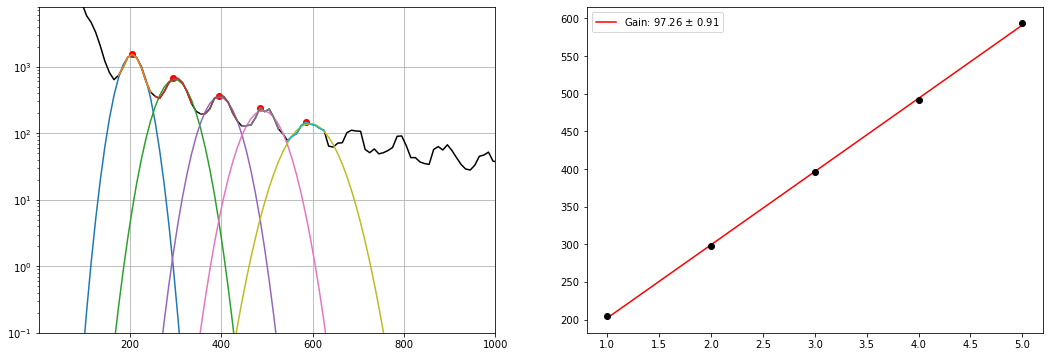

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_30.h5
Guess:  [1442, 205.0375457875458, 10]
Params:  [1400.67588193  204.24755139   24.75505909]
Guess:  [693, 295.0540293040293, 10]
Params:  [663.94142983 298.4566345   30.11071526]
Guess:  [397, 405.0741758241758, 10]
Params:  [373.23459245 398.25226609  28.84567396]
Guess:  [260, 495.09065934065933, 10]
Params:  [220.8118265  493.76713599  32.16858426]
Guess:  [162, 595.1089743589744, 10]
Params:  [144.63999481 590.55188024  35.06059873]


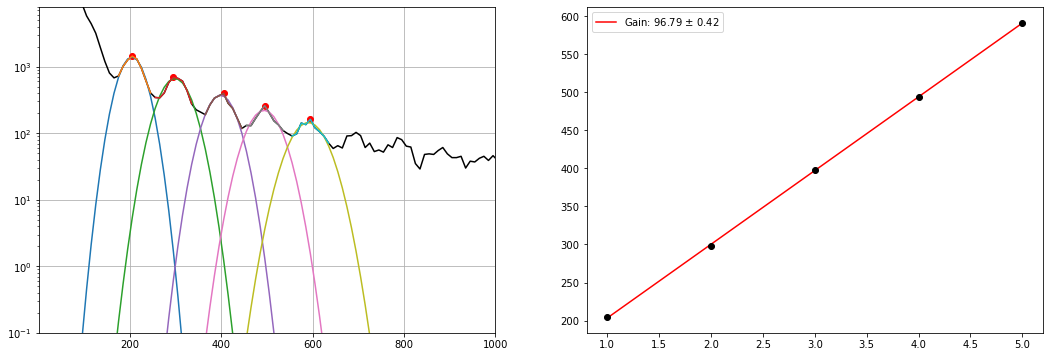

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_29.h5
Guess:  [1557, 205.0375457875458, 10]
Params:  [1497.21303688  204.26677262   23.98320867]
Guess:  [706, 295.0540293040293, 10]
Params:  [667.07107154 298.61880683  29.59611113]
Guess:  [398, 405.0741758241758, 10]
Params:  [374.7222353  397.53888016  28.54608406]
Guess:  [219, 485.0888278388278, 10]
Params:  [213.58356455 489.86421132  36.92369833]
Guess:  [143, 595.1089743589744, 10]
Params:  [140.35787542 588.41679325  40.21432607]


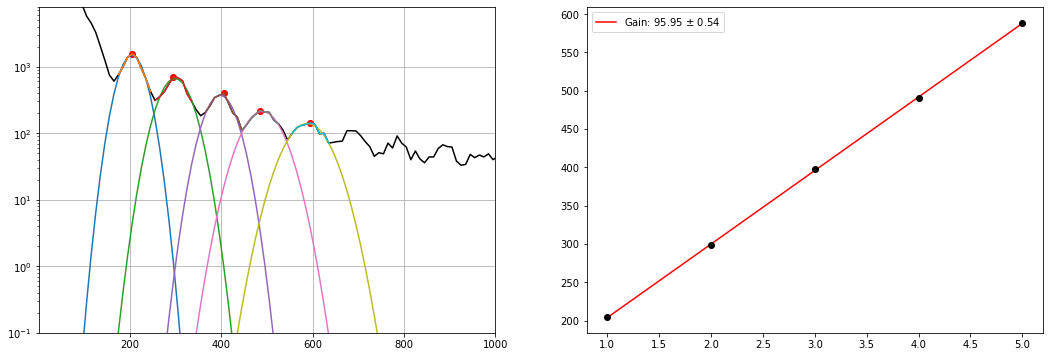

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_28.h5
Guess:  [1570, 205.0375457875458, 10]
Params:  [1551.39358604  203.32214865   22.46778306]
Guess:  [680, 295.0540293040293, 10]
Params:  [666.93610574 297.18345517  27.96450432]
Guess:  [389, 395.0723443223443, 10]
Params:  [368.30320885 394.79923506  28.74186042]
Guess:  [254, 495.09065934065933, 10]
Params:  [239.87579453 492.0296686   30.41316037]
Guess:  [163, 585.1071428571429, 10]
Params:  [148.74409418 584.4526556   33.96009812]


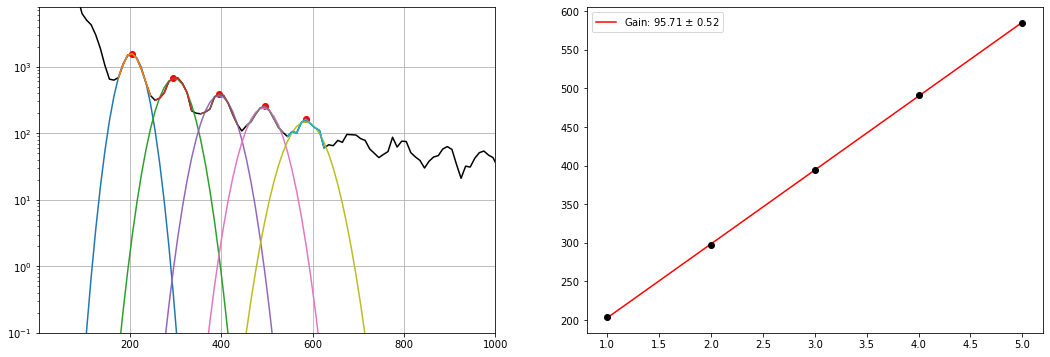

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_27.h5
Guess:  [1466, 205.0375457875458, 10]
Params:  [1437.28128852  203.25080407   22.83865135]
Guess:  [685, 305.0558608058608, 10]
Params:  [664.32991766 299.70234427  25.72265367]
Guess:  [397, 395.0723443223443, 10]
Params:  [372.46299329 395.51188605  28.15196424]
Guess:  [240, 495.09065934065933, 10]
Params:  [214.04342759 493.66474382  29.9761248 ]
Guess:  [162, 595.1089743589744, 10]
Params:  [154.06369603 592.5669022   29.57074154]


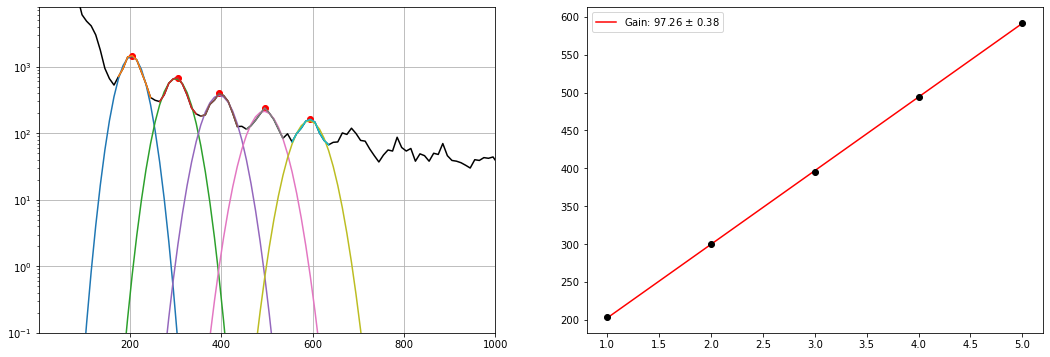

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_26.h5
Guess:  [1412, 205.0375457875458, 10]
Params:  [1392.07333397  203.42238456   26.63696493]
Guess:  [654, 295.0540293040293, 10]
Params:  [626.89823773 299.1474495   32.56710955]
Guess:  [405, 405.0741758241758, 10]
Params:  [372.4028096  398.25695403  29.47680175]
Guess:  [246, 495.09065934065933, 10]
Params:  [222.38124745 494.76533676  32.39337821]
Guess:  [156, 605.1108058608058, 10]
Params:  [138.43436771 593.68895037  39.91581212]


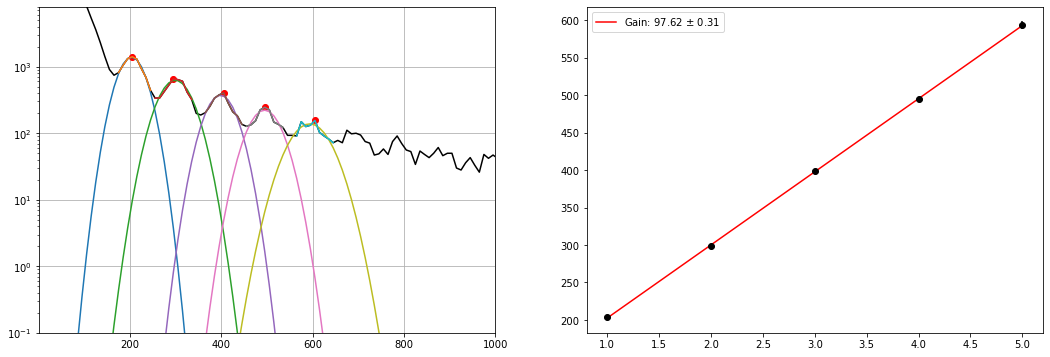

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_25.h5
Guess:  [1511, 205.0375457875458, 10]
Params:  [1458.38253749  204.19329517   24.44300571]
Guess:  [680, 305.0558608058608, 10]
Params:  [671.47231948 300.40459681  28.54886004]
Guess:  [392, 395.0723443223443, 10]
Params:  [361.8566148  396.65259049  32.40447729]
Guess:  [253, 495.09065934065933, 10]
Params:  [241.41674129 493.34804382  27.99135044]
Guess:  [150, 585.1071428571429, 10]
Params:  [137.72247047 589.8586018   41.71896996]


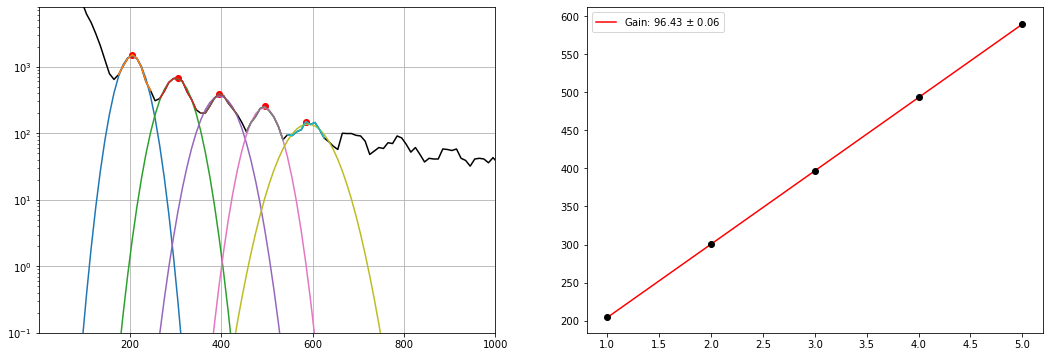

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_24.h5
Guess:  [1512, 205.0375457875458, 10]
Params:  [1515.56321559  203.39745196   23.14418247]
Guess:  [689, 305.0558608058608, 10]
Params:  [687.15574606 299.19630432  26.63231933]
Guess:  [407, 395.0723443223443, 10]
Params:  [398.19471758 394.10057978  27.4472409 ]
Guess:  [236, 485.0888278388278, 10]
Params:  [227.25461412 488.45683416  33.96904875]
Guess:  [153, 585.1071428571429, 10]
Params:  [150.62107307 586.35530698  31.37315407]


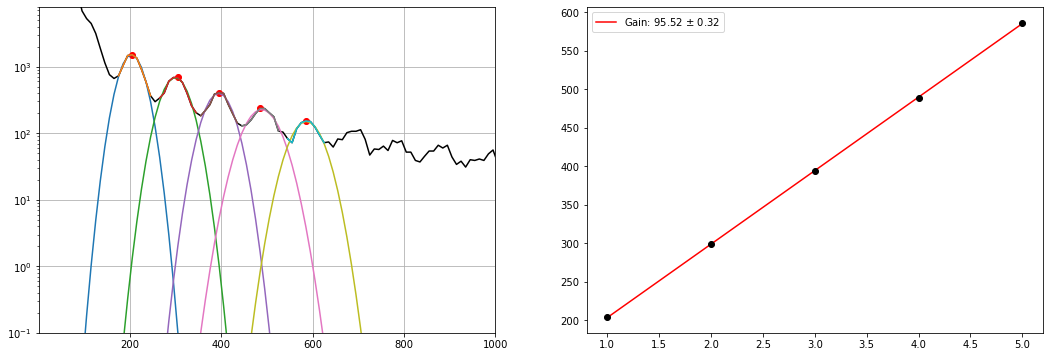

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_23.h5
Guess:  [1487, 205.0375457875458, 10]
Params:  [1487.79082165  202.69977856   23.92913707]
Guess:  [714, 295.0540293040293, 10]
Params:  [685.916944   297.54855153  27.65796905]
Guess:  [438, 395.0723443223443, 10]
Params:  [388.71448596 395.34877002  28.17894752]
Guess:  [253, 495.09065934065933, 10]
Params:  [227.54448015 493.22110561  31.63524921]
Guess:  [154, 595.1089743589744, 10]
Params:  [142.07845252 591.34227302  36.02709374]


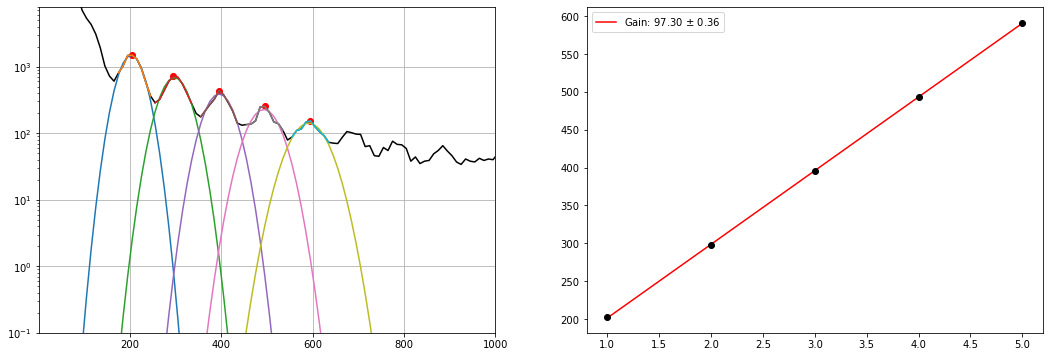

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_22.h5
Guess:  [1527, 205.0375457875458, 10]
Params:  [1469.78443583  204.10517696   23.09835859]
Guess:  [651, 305.0558608058608, 10]
Params:  [650.9803805  300.43471081  27.20008378]
Guess:  [375, 395.0723443223443, 10]
Params:  [358.09239143 394.9968195   29.55124943]
Guess:  [227, 485.0888278388278, 10]
Params:  [219.88146975 492.67244769  35.0921016 ]
Guess:  [170, 595.1089743589744, 10]
Params:  [142.38475379 592.50512775  32.06314364]


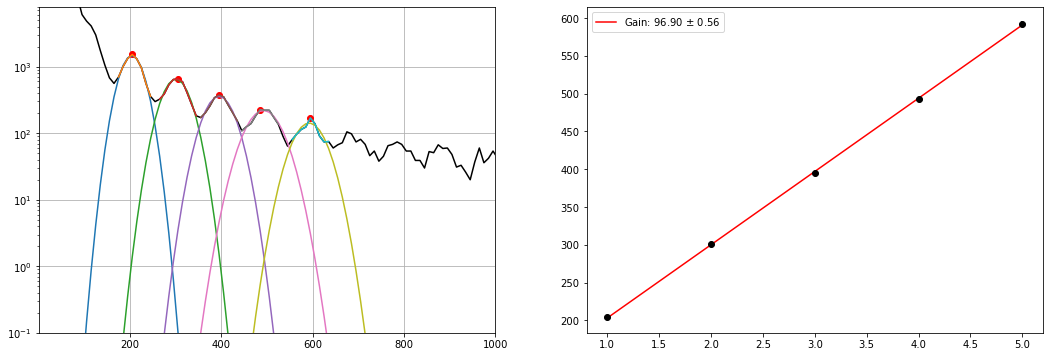

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_21.h5
Guess:  [1495, 205.0375457875458, 10]
Params:  [1416.20841485  203.58301871   24.28873107]
Guess:  [693, 305.0558608058608, 10]
Params:  [666.31973476 299.79957722  26.61946739]
Guess:  [389, 395.0723443223443, 10]
Params:  [372.37373912 395.25608272  29.55040821]
Guess:  [234, 485.0888278388278, 10]
Params:  [221.25469031 490.30663142  35.51275631]
Guess:  [163, 595.1089743589744, 10]
Params:  [146.4000081  592.75750902  32.57930665]


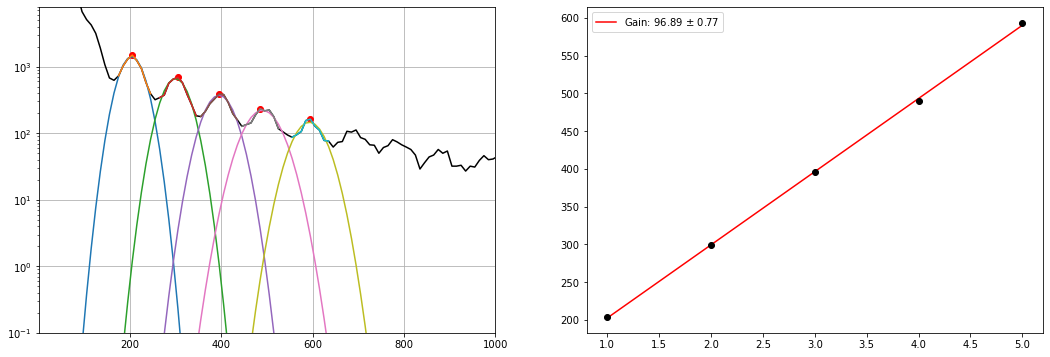

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_20.h5
Guess:  [1463, 205.0375457875458, 10]
Params:  [1445.97498002  203.64073549   25.0719423 ]
Guess:  [671, 305.0558608058608, 10]
Params:  [655.28110364 300.06922495  27.30919131]
Guess:  [352, 395.0723443223443, 10]
Params:  [345.04164562 395.25217521  32.59537145]
Guess:  [268, 495.09065934065933, 10]
Params:  [232.72068194 495.37186572  29.52881985]
Guess:  [147, 595.1089743589744, 10]
Params:  [134.64851361 589.46570085  42.48461643]


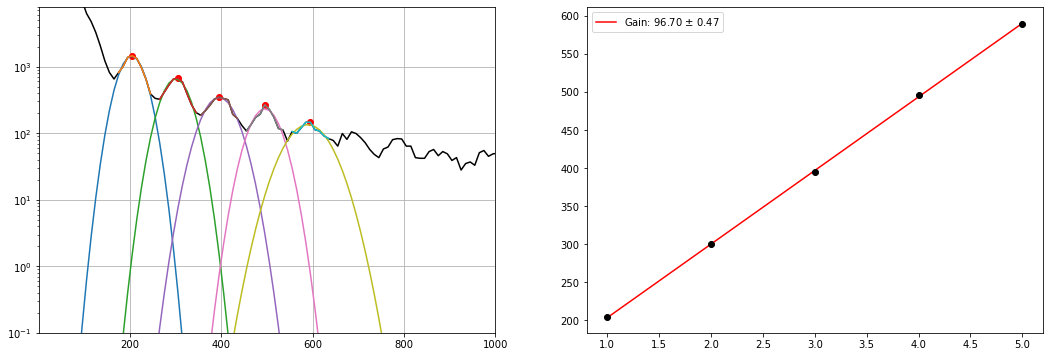

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_19.h5
Guess:  [1513, 205.0375457875458, 10]
Params:  [1427.05059335  204.2179985    24.55642409]
Guess:  [679, 295.0540293040293, 10]
Params:  [637.14461437 297.96888277  30.64856569]
Guess:  [364, 405.0741758241758, 10]
Params:  [353.89057291 396.42492208  30.88236804]
Guess:  [244, 495.09065934065933, 10]
Params:  [223.82298798 491.25870936  32.34855257]
Guess:  [160, 595.1089743589744, 10]
Params:  [152.9069447  589.12519418  33.10697869]


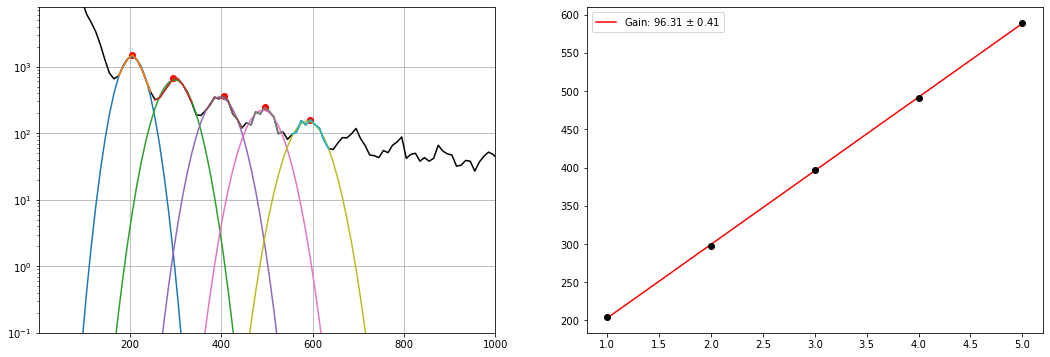

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_18.h5
Guess:  [1419, 205.0375457875458, 10]
Params:  [1386.08677961  204.38889464   25.34743625]
Guess:  [748, 295.0540293040293, 10]
Params:  [668.68839592 298.29001959  28.08534431]
Guess:  [401, 405.0741758241758, 10]
Params:  [352.3254782  398.58451971  31.46854084]
Guess:  [216, 495.09065934065933, 10]
Params:  [211.46370575 490.88168224  32.7286046 ]
Guess:  [150, 585.1071428571429, 10]
Params:  [141.87631875 586.66861659  34.14051046]


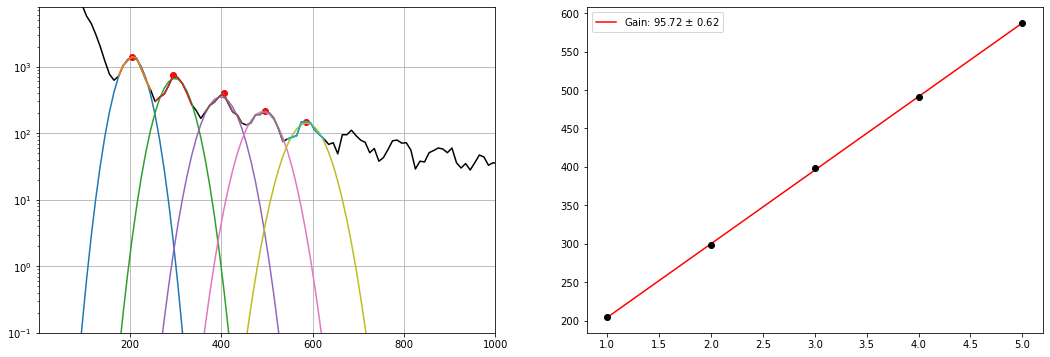

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_17.h5
Guess:  [1630, 205.0375457875458, 10]
Params:  [1491.7330378   203.16494289   23.52020448]
Guess:  [762, 295.0540293040293, 10]
Params:  [707.63662687 298.07010862  26.95501633]
Guess:  [409, 395.0723443223443, 10]
Params:  [387.77264545 396.44364203  29.51143728]
Guess:  [247, 495.09065934065933, 10]
Params:  [228.02696632 492.0910136   29.53681142]
Guess:  [180, 595.1089743589744, 10]
Params:  [157.31452853 588.23220454  31.95961872]


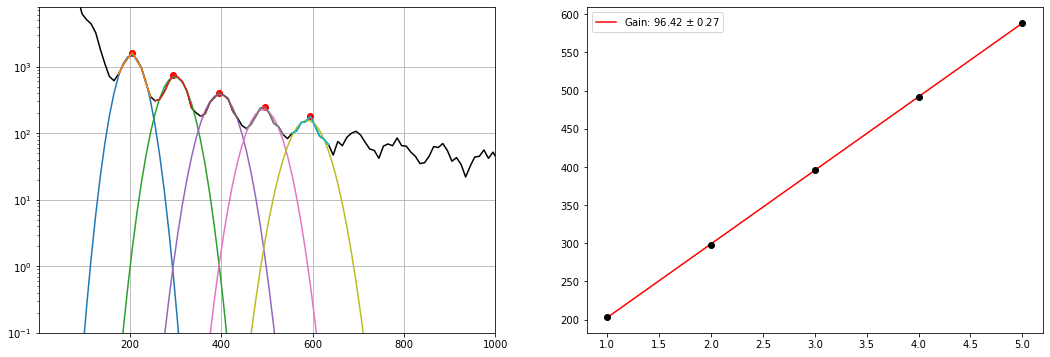

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_16.h5
Guess:  [1516, 205.0375457875458, 10]
Params:  [1494.77459242  203.79275023   24.10132667]
Guess:  [694, 295.0540293040293, 10]
Params:  [660.61268663 298.57644781  29.92589165]
Guess:  [380, 395.0723443223443, 10]
Params:  [354.33379144 394.69537376  31.54616282]
Guess:  [241, 495.09065934065933, 10]
Params:  [230.99896427 495.19397661  31.47560989]
Guess:  [154, 595.1089743589744, 10]
Params:  [149.66858123 587.40939169  33.36653904]


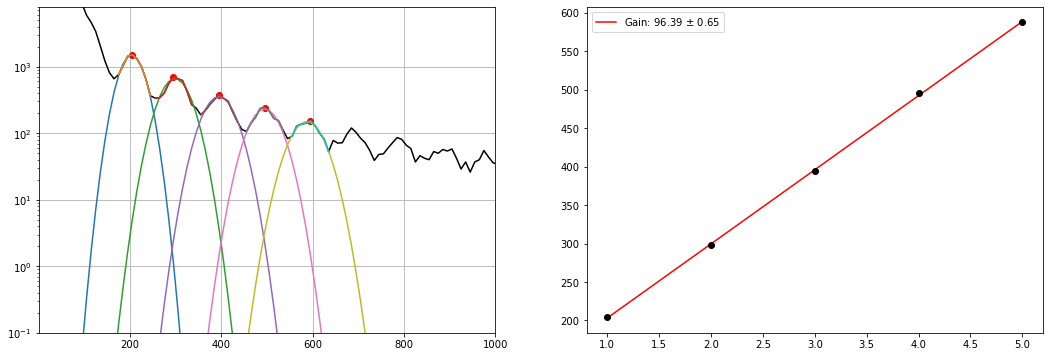

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_15.h5
Guess:  [1516, 205.0375457875458, 10]
Params:  [1496.44549612  203.45476371   23.86931654]
Guess:  [715, 295.0540293040293, 10]
Params:  [692.52578609 298.37426949  26.64811215]
Guess:  [390, 395.0723443223443, 10]
Params:  [370.51991829 395.70145332  30.45833097]
Guess:  [230, 495.09065934065933, 10]
Params:  [222.44660355 491.71199776  33.06933121]
Guess:  [146, 595.1089743589744, 10]
Params:  [142.34253614 590.00690101  34.29763456]


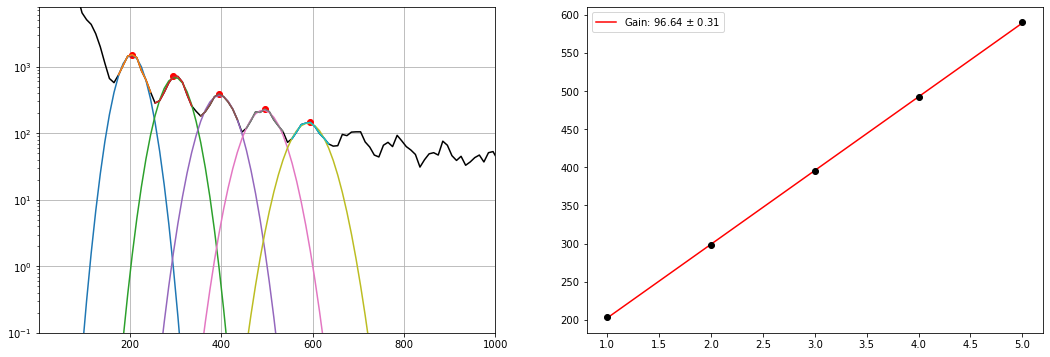

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_14.h5
Guess:  [1611, 205.0375457875458, 10]
Params:  [1545.25974065  203.11145844   22.99638666]
Guess:  [700, 305.0558608058608, 10]
Params:  [677.76612665 299.00274316  26.40185705]
Guess:  [405, 395.0723443223443, 10]
Params:  [376.22515697 394.36752873  28.94699291]
Guess:  [272, 495.09065934065933, 10]
Params:  [237.41170409 494.42687982  30.86163062]
Guess:  [169, 595.1089743589744, 10]
Params:  [154.83169766 590.59050147  30.68505051]


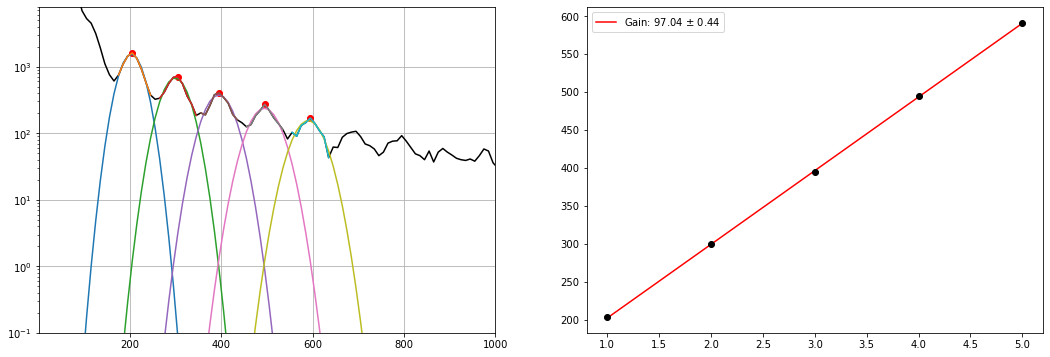

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_13.h5
Guess:  [1542, 205.0375457875458, 10]
Params:  [1499.17293725  203.36765493   23.27869732]
Guess:  [677, 295.0540293040293, 10]
Params:  [658.61833457 298.45828927  27.68978422]
Guess:  [368, 395.0723443223443, 10]
Params:  [356.55196861 394.5070366   30.18719261]
Guess:  [229, 495.09065934065933, 10]
Params:  [228.26035087 492.32343283  31.14991511]
Guess:  [160, 605.1108058608058, 10]
Params:  [147.46839422 591.00036497  35.89161853]


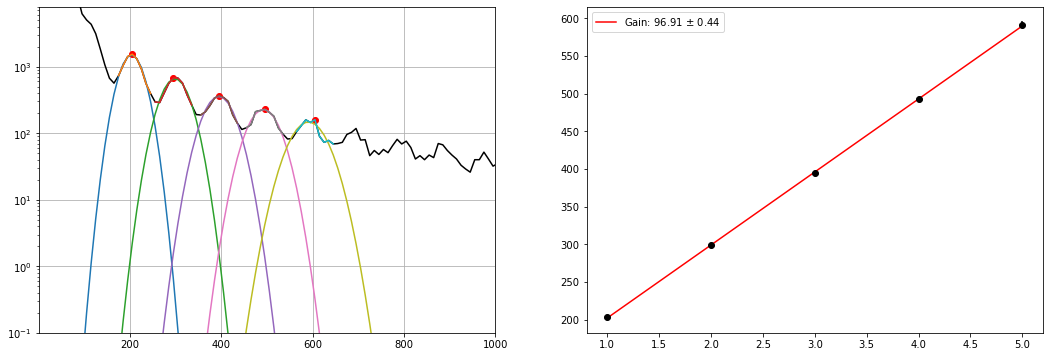

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_12.h5
Guess:  [1579, 205.0375457875458, 10]
Params:  [1535.29736568  203.90904319   23.21852328]
Guess:  [760, 295.0540293040293, 10]
Params:  [691.14709485 297.79877851  27.51780361]
Guess:  [413, 405.0741758241758, 10]
Params:  [376.58171533 396.17812444  30.08268151]
Guess:  [276, 495.09065934065933, 10]
Params:  [243.90316556 492.91720982  30.61955179]
Guess:  [172, 595.1089743589744, 10]
Params:  [155.05681088 589.97314217  30.65049679]


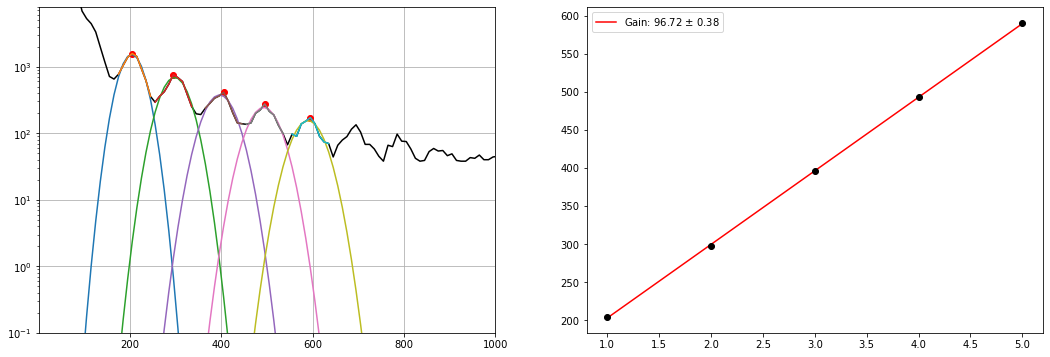

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_11.h5
Guess:  [1557, 205.0375457875458, 10]
Params:  [1494.56059873  203.68386349   23.27523545]
Guess:  [707, 305.0558608058608, 10]
Params:  [699.09688803 300.25329671  26.68591281]
Guess:  [397, 395.0723443223443, 10]
Params:  [369.09861083 395.31107799  29.74027175]
Guess:  [255, 495.09065934065933, 10]
Params:  [242.12347568 495.08875439  29.64677874]
Guess:  [157, 595.1089743589744, 10]
Params:  [148.06817021 589.26131406  37.49320575]


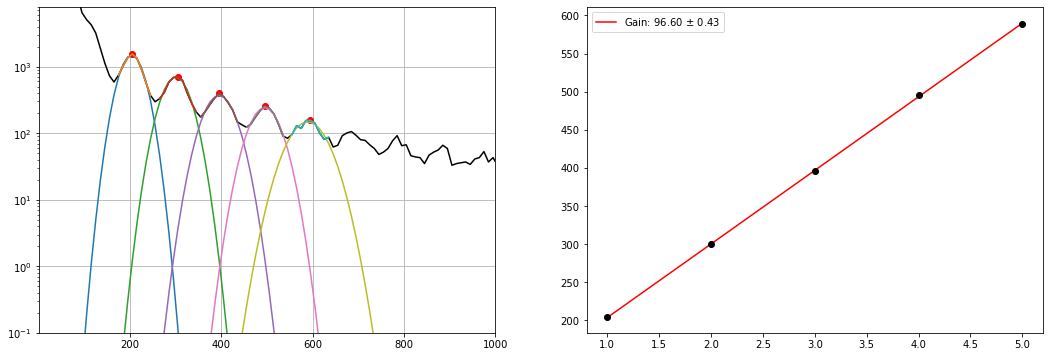

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_10.h5
Guess:  [1599, 205.0375457875458, 10]
Params:  [1570.92093449  203.3407446    22.20057356]
Guess:  [697, 295.0540293040293, 10]
Params:  [672.51862838 297.63027234  27.1586286 ]
Guess:  [417, 395.0723443223443, 10]
Params:  [388.26708611 394.63157793  28.90232322]
Guess:  [234, 505.09249084249086, 10]
Params:  [227.73528233 495.59714803  31.37123377]
Guess:  [149, 595.1089743589744, 10]
Params:  [136.32003959 594.06416976  34.16429894]


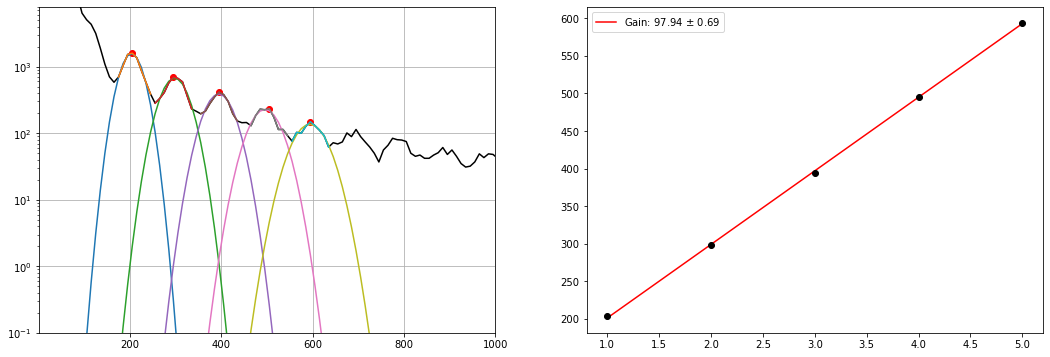

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_9.h5
Guess:  [1519, 205.0375457875458, 10]
Params:  [1476.22668856  203.23628586   23.30338414]
Guess:  [701, 305.0558608058608, 10]
Params:  [688.48342012 300.80643528  26.21518184]
Guess:  [390, 385.0705128205128, 10]
Params:  [358.76960249 390.88150728  35.70872525]
Guess:  [202, 495.09065934065933, 10]
Params:  [197.17170807 493.58071329  35.43196589]
Guess:  [162, 585.1071428571429, 10]
Params:  [142.45414839 586.9887613   38.6544493 ]


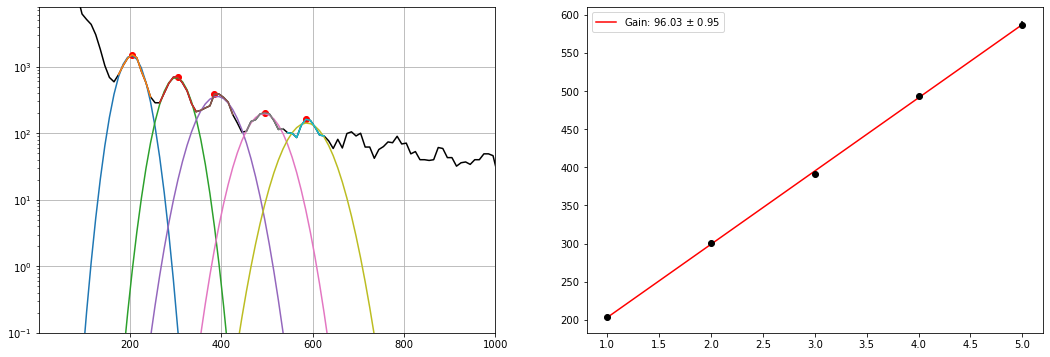

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_8.h5
Guess:  [1543, 205.0375457875458, 10]
Params:  [1511.3061854   203.79227523   23.42684524]
Guess:  [719, 305.0558608058608, 10]
Params:  [700.02330467 300.20254865  25.75426787]
Guess:  [415, 395.0723443223443, 10]
Params:  [392.69894816 395.22038988  28.47378753]
Guess:  [229, 505.09249084249086, 10]
Params:  [210.87224051 494.02014883  32.2357353 ]
Guess:  [155, 595.1089743589744, 10]
Params:  [143.3303901  588.13023118  36.20459892]


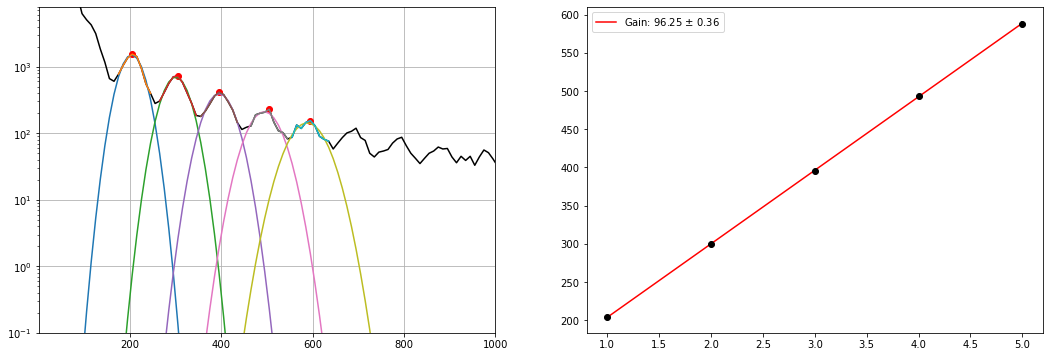

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_7.h5
Guess:  [1549, 205.0375457875458, 10]
Params:  [1487.39407014  204.30816162   23.60660838]
Guess:  [717, 295.0540293040293, 10]
Params:  [657.34856824 299.27420224  28.97863069]
Guess:  [402, 395.0723443223443, 10]
Params:  [380.30219839 395.30719623  30.11026072]
Guess:  [253, 495.09065934065933, 10]
Params:  [226.5137983  492.60045398  31.51946567]
Guess:  [164, 595.1089743589744, 10]
Params:  [164.66770233 590.34456387  29.26884852]


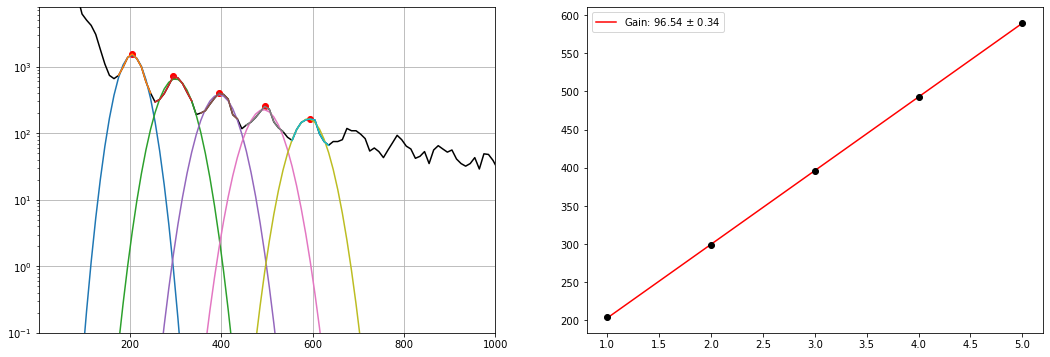

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_6.h5
Guess:  [1578, 205.0375457875458, 10]
Params:  [1524.21665845  203.12538401   23.29410787]
Guess:  [716, 305.0558608058608, 10]
Params:  [686.25626035 300.33339928  26.63365191]
Guess:  [388, 395.0723443223443, 10]
Params:  [359.85683292 396.66057959  30.40504414]
Guess:  [251, 495.09065934065933, 10]
Params:  [235.8130507  493.28525886  30.60101292]
Guess:  [163, 595.1089743589744, 10]
Params:  [149.05924268 591.7761905   31.25032392]


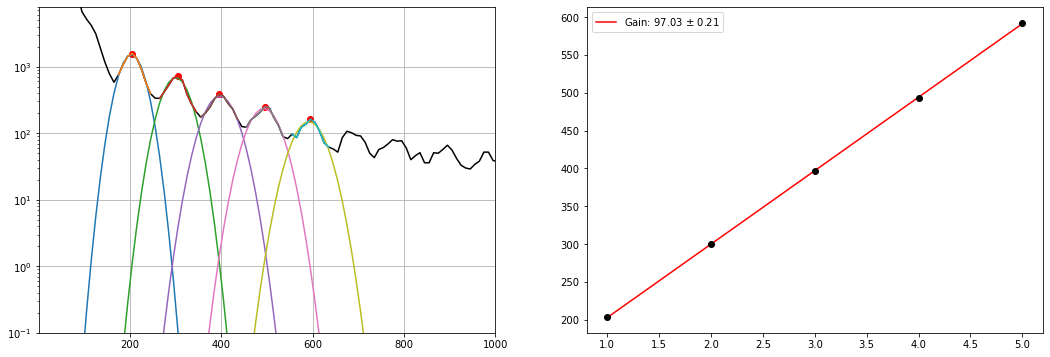

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_5.h5
Guess:  [1587, 205.0375457875458, 10]
Params:  [1529.6215049   203.98086303   22.81926234]
Guess:  [759, 295.0540293040293, 10]
Params:  [702.31950349 297.95669467  26.61084286]
Guess:  [390, 405.0741758241758, 10]
Params:  [375.18179237 395.64987415  28.16773639]
Guess:  [262, 495.09065934065933, 10]
Params:  [233.64844682 493.36614577  30.81664315]
Guess:  [161, 595.1089743589744, 10]
Params:  [154.12995874 589.02641142  29.16140009]


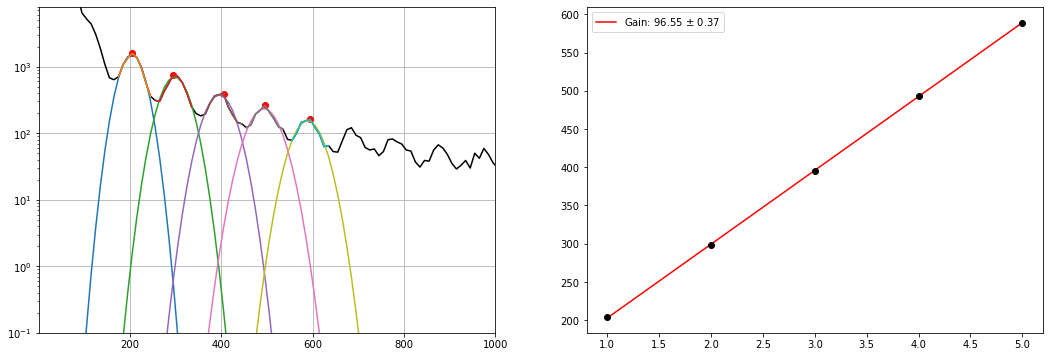

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_4.h5
Guess:  [1448, 205.0375457875458, 10]
Params:  [1433.4609211   204.10278586   22.45215605]
Guess:  [679, 305.0558608058608, 10]
Params:  [644.83221756 299.62624503  26.10254018]
Guess:  [363, 405.0741758241758, 10]
Params:  [343.67472494 397.01623722  28.71895853]
Guess:  [214, 495.09065934065933, 10]
Params:  [207.0079016  494.067677    31.72193035]
Guess:  [154, 585.1071428571429, 10]
Params:  [139.21041277 588.83798878  37.6274641 ]


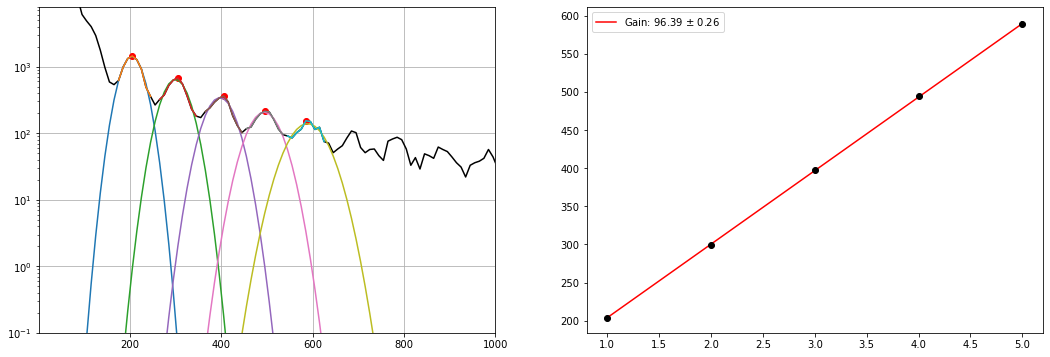

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_3.h5
Guess:  [1525, 205.0375457875458, 10]
Params:  [1455.53715101  203.80304723   24.30050713]
Guess:  [695, 295.0540293040293, 10]
Params:  [660.35868737 299.64185027  28.8520859 ]
Guess:  [384, 395.0723443223443, 10]
Params:  [377.74077744 395.54572949  29.01252615]
Guess:  [254, 485.0888278388278, 10]
Params:  [234.37165277 488.80281179  33.59702663]
Guess:  [158, 585.1071428571429, 10]
Params:  [142.61055841 589.37284012  39.75630321]


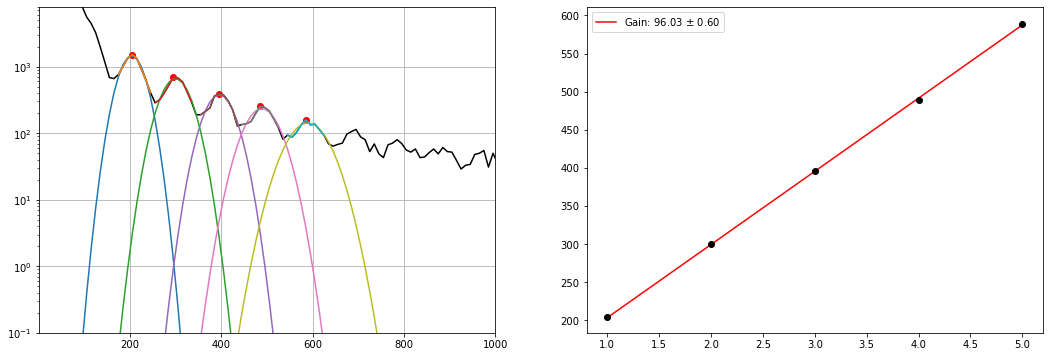

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_2.h5
Guess:  [1434, 205.0375457875458, 10]
Params:  [1385.13769742  204.25925272   25.47858205]
Guess:  [715, 305.0558608058608, 10]
Params:  [669.68581655 300.43742996  27.97316557]
Guess:  [359, 405.0741758241758, 10]
Params:  [355.16524254 397.7557636   31.3181558 ]
Guess:  [244, 495.09065934065933, 10]
Params:  [220.8177972  493.98428541  34.6735055 ]
Guess:  [159, 585.1071428571429, 10]
Params:  [146.27922803 588.4611948   36.00615558]


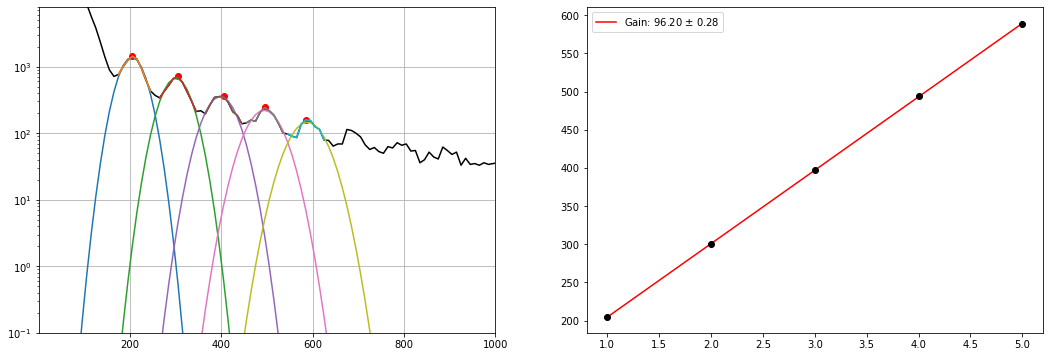

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_1.h5
Guess:  [1326, 205.0375457875458, 10]
Params:  [1352.16499298  204.32511863   27.58686432]
Guess:  [671, 305.0558608058608, 10]
Params:  [634.30828972 299.65859686  30.58372714]
Guess:  [375, 405.0741758241758, 10]
Params:  [354.39891825 399.0988074   31.56593453]
Guess:  [243, 495.09065934065933, 10]
Params:  [228.61721982 493.47875557  35.73978479]
Guess:  [146, 605.1108058608058, 10]
Params:  [130.63163697 594.85669137  42.09567461]


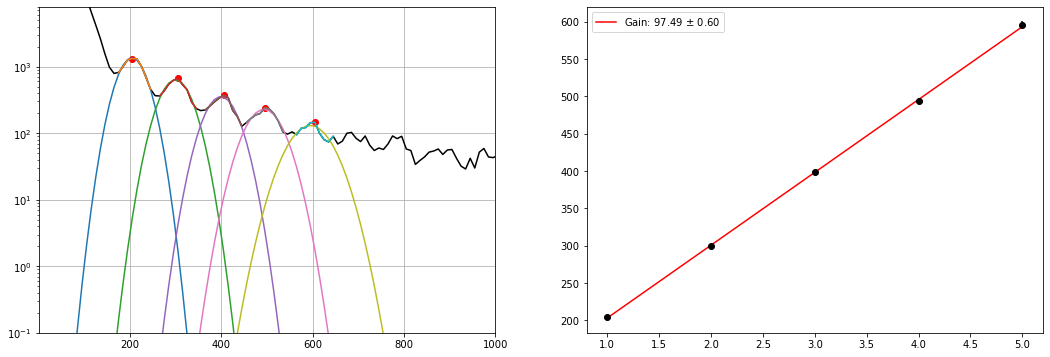

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_source_0.h5
Guess:  [1340, 205.0375457875458, 10]
Params:  [1307.30178709  204.0408482    27.94029339]
Guess:  [673, 305.0558608058608, 10]
Params:  [646.68556092 299.97108294  29.30121095]
Guess:  [359, 395.0723443223443, 10]
Params:  [351.10256467 395.1876152   31.34854722]
Guess:  [218, 485.0888278388278, 10]
Params:  [202.88821797 490.79391978  38.73786191]
Guess:  [141, 585.1071428571429, 10]
Params:  [127.49489801 585.16967292  45.6737198 ]


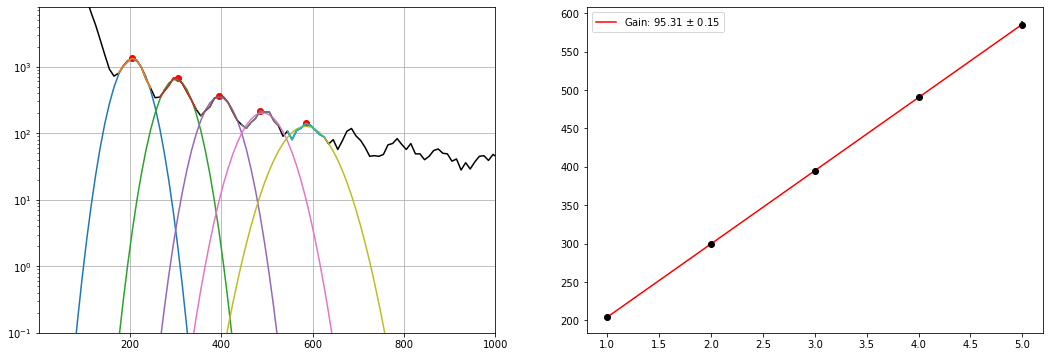

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_34.h5
Guess:  [401, 205.0375457875458, 10]
Params:  [410.13683229 202.55635922  25.64375071]
Guess:  [320, 295.0540293040293, 10]
Params:  [278.14551066 296.62649839  31.55743717]
Guess:  [220, 385.0705128205128, 10]
Params:  [216.97635914 384.0662661   33.69618242]
Guess:  [168, 485.0888278388278, 10]
Params:  [155.48402535 476.7436367   45.26869686]


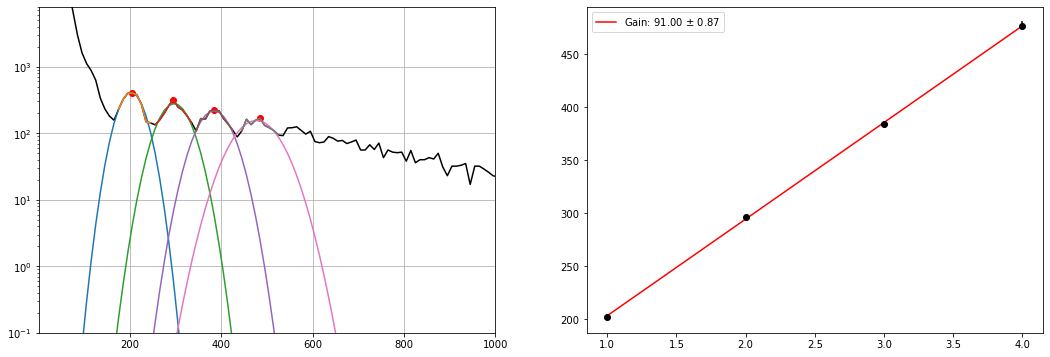

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_33.h5
Guess:  [431, 205.0375457875458, 10]
Params:  [400.98766391 202.46048173  25.38876393]
Guess:  [302, 295.0540293040293, 10]
Params:  [286.79845886 293.7482612   30.05246208]
Guess:  [206, 395.0723443223443, 10]
Params:  [189.12223441 382.56712856  42.46529313]
Guess:  [163, 475.0869963369963, 10]
Params:  [148.30747157 477.46024072  46.60574221]


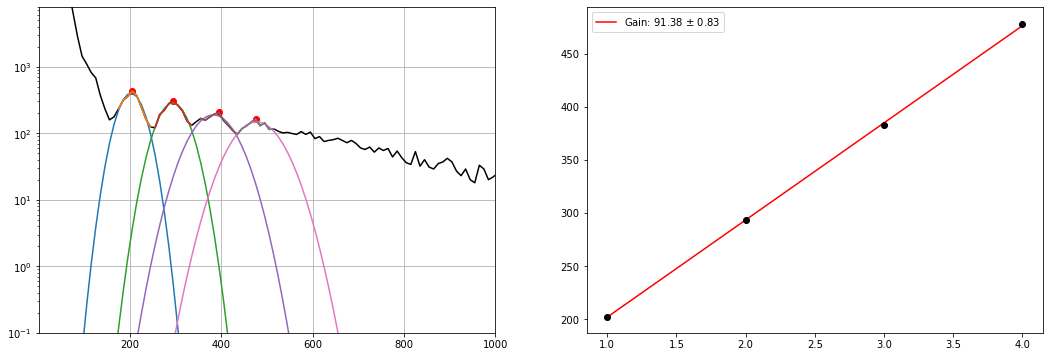

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_32.h5
Guess:  [394, 195.03571428571428, 10]
Params:  [376.44805074 199.8808969   26.29914878]
Guess:  [279, 295.0540293040293, 10]
Params:  [263.02029216 293.21280066  30.43133083]
Guess:  [200, 385.0705128205128, 10]
Params:  [195.69832148 383.19072223  38.88168386]
fit failed


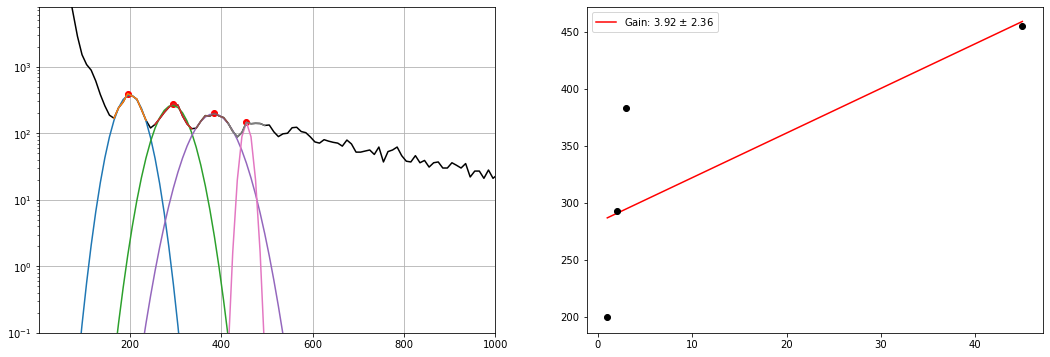

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_31.h5
Guess:  [393, 205.0375457875458, 10]
Params:  [396.58639654 203.29109055  25.44584944]
Guess:  [301, 295.0540293040293, 10]
Params:  [278.21425282 295.12608756  29.04825339]
Guess:  [199, 385.0705128205128, 10]
Params:  [197.4983294  383.47127312  38.55502698]
Guess:  [157, 475.0869963369963, 10]
Params:  [148.35365238 473.56696594  44.70839806]


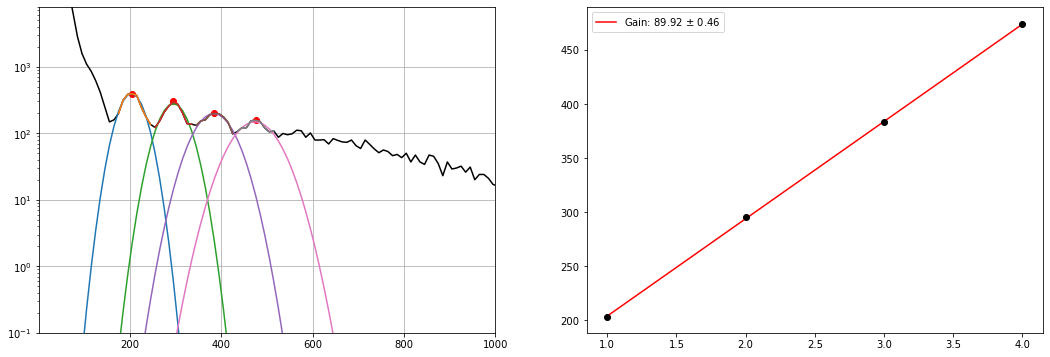

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_30.h5
Guess:  [423, 205.0375457875458, 10]
Params:  [399.65158688 202.95783834  24.75587003]
Guess:  [292, 295.0540293040293, 10]
Params:  [266.54145439 295.45866097  29.04239339]
Guess:  [199, 375.06868131868134, 10]
Params:  [187.10463033 382.37047817  44.79519825]
Guess:  [157, 495.09065934065933, 10]
Params:  [145.73652253 466.55828048  70.18445388]


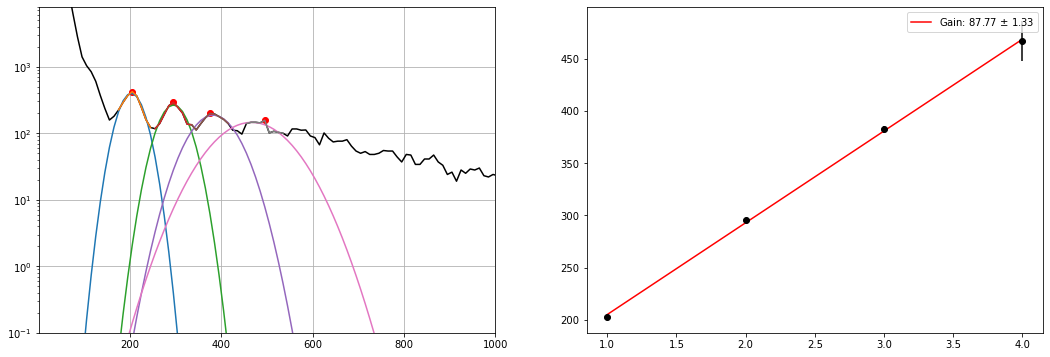

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_29.h5
Guess:  [418, 205.0375457875458, 10]
Params:  [384.9524158  202.36742695  24.85949651]
Guess:  [260, 295.0540293040293, 10]
Params:  [249.95593474 295.03073207  31.72282716]
Guess:  [207, 395.0723443223443, 10]
Params:  [199.80559315 387.17181545  37.19144571]
Guess:  [141, 485.0888278388278, 10]
Params:  [132.35244453 480.60266128  53.34168602]


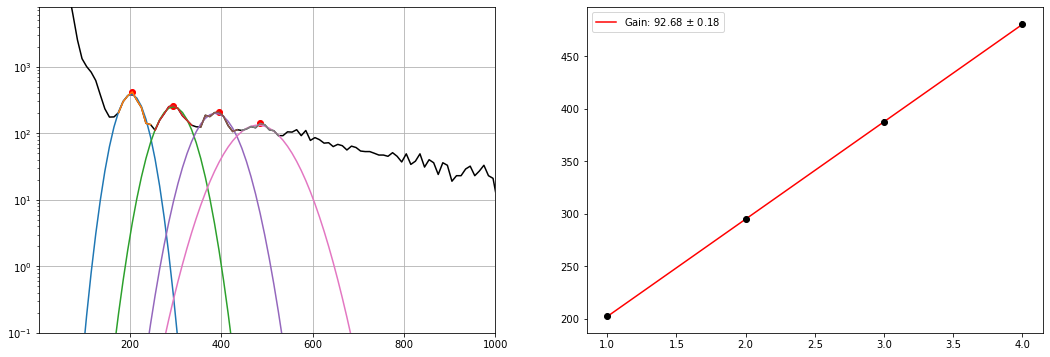

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_28.h5
Guess:  [428, 205.0375457875458, 10]
Params:  [400.75227825 201.9450187   25.48708135]
Guess:  [287, 295.0540293040293, 10]
Params:  [262.70267765 291.6207992   32.58374033]
Guess:  [229, 385.0705128205128, 10]
Params:  [210.94165926 384.87768503  36.37128333]
Guess:  [146, 475.0869963369963, 10]
Params:  [144.64474629 477.12178842  49.95433002]


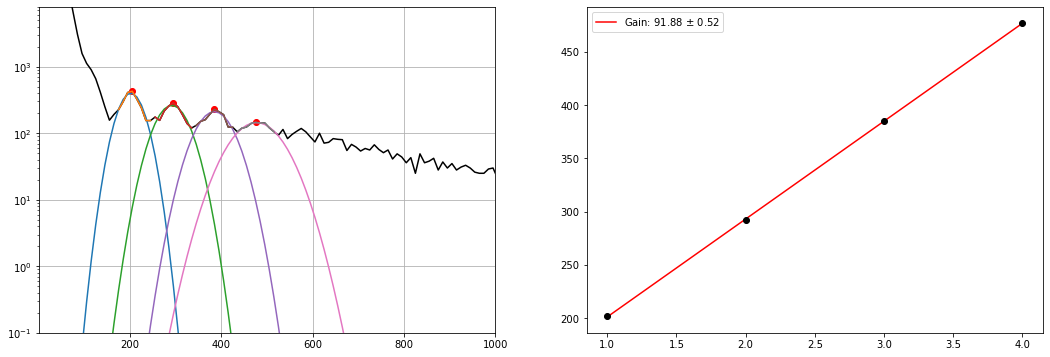

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_27.h5
Guess:  [415, 205.0375457875458, 10]
Params:  [385.50465795 201.62488305  24.54174077]
Guess:  [293, 295.0540293040293, 10]
Params:  [268.70518075 293.99435286  29.16428662]
Guess:  [213, 385.0705128205128, 10]
Params:  [195.97031541 383.90263905  35.01361449]
Guess:  [158, 475.0869963369963, 10]
Params:  [154.72679237 471.20805143  40.51628804]


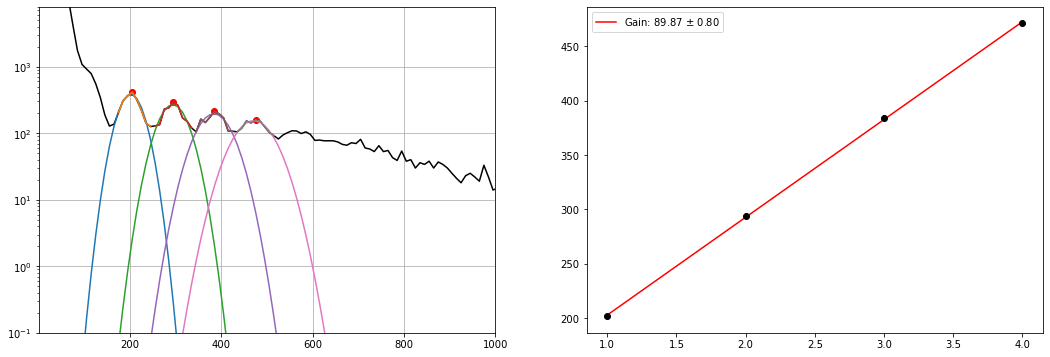

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_26.h5
Guess:  [398, 205.0375457875458, 10]
Params:  [373.0954297  202.40940185  26.12548793]
Guess:  [271, 295.0540293040293, 10]
Params:  [250.46096908 293.24345686  33.0323066 ]
Guess:  [195, 385.0705128205128, 10]
Params:  [176.20444803 388.81264665  51.11230321]
Guess:  [142, 485.0888278388278, 10]
Params:  [139.46346887 480.67634296  52.62019302]


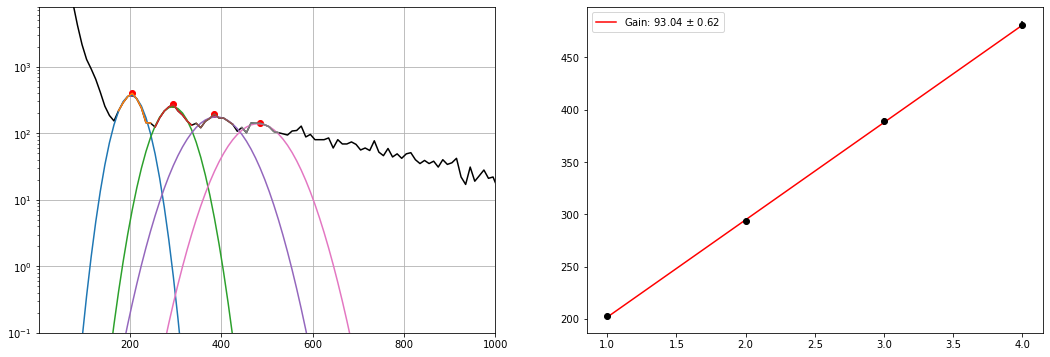

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_25.h5
Guess:  [386, 205.0375457875458, 10]
Params:  [364.93164364 203.87775146  26.98687916]
Guess:  [277, 295.0540293040293, 10]
Params:  [255.30549391 294.10154657  31.80321784]
Guess:  [190, 375.06868131868134, 10]
Params:  [184.90331632 382.51684274  44.69664763]
Guess:  [157, 475.0869963369963, 10]
Params:  [146.29386459 477.02491598  51.36056476]


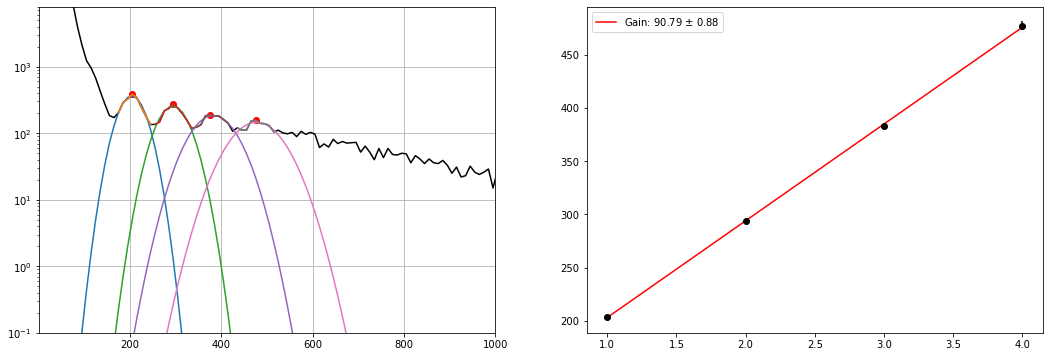

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_24.h5
Guess:  [405, 205.0375457875458, 10]
Params:  [396.7514592  202.45908568  25.36436558]
Guess:  [262, 295.0540293040293, 10]
Params:  [253.10250089 294.73653832  31.76574495]
Guess:  [211, 375.06868131868134, 10]
Params:  [206.42002708 380.99611993  39.05193226]
Guess:  [150, 455.08333333333337, 10]
Params:  [135.34793973 480.99742164 102.67518867]


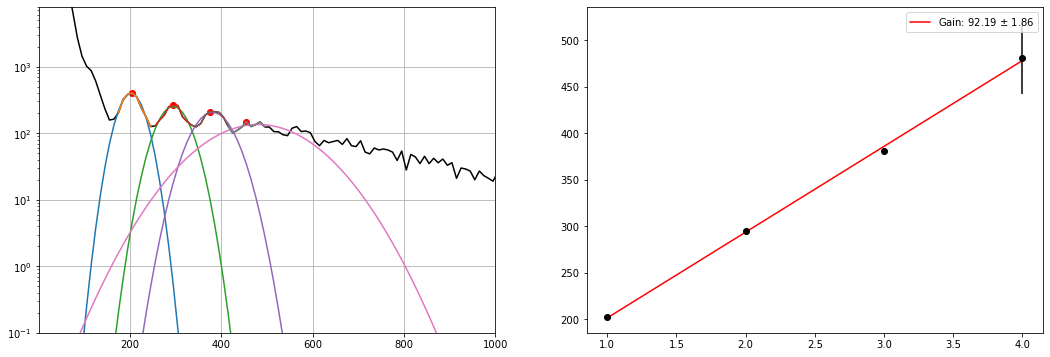

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_23.h5
Guess:  [458, 195.03571428571428, 10]
Params:  [443.20683578 200.35607994  23.53074855]
Guess:  [304, 295.0540293040293, 10]
Params:  [281.50152404 291.89416259  30.26277617]
Guess:  [226, 375.06868131868134, 10]
Params:  [207.6491279  381.78086247  38.25294786]
Guess:  [156, 465.08516483516485, 10]
Params:  [146.99685123 471.38165711  53.02805116]


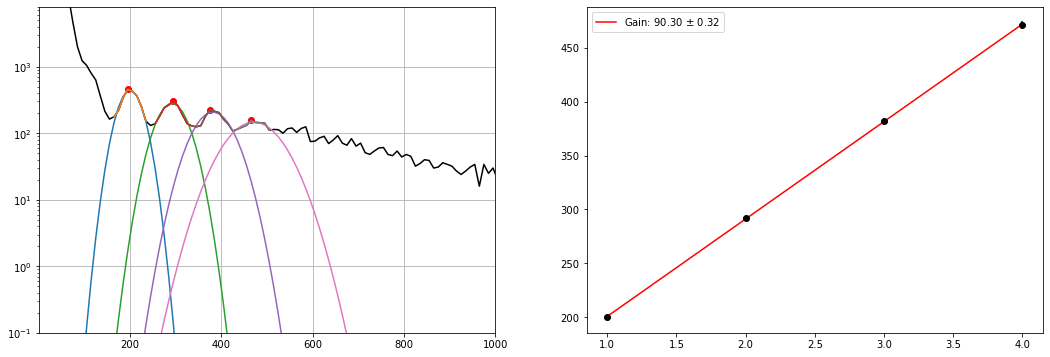

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_22.h5
Guess:  [395, 205.0375457875458, 10]
Params:  [388.01122786 201.4201136   24.42346689]
Guess:  [286, 295.0540293040293, 10]
Params:  [267.83027864 294.12092356  28.72228385]
Guess:  [213, 385.0705128205128, 10]
Params:  [206.28479309 382.0578581   34.74367719]
Guess:  [155, 475.0869963369963, 10]
Params:  [137.62200955 473.87696959  43.66490296]


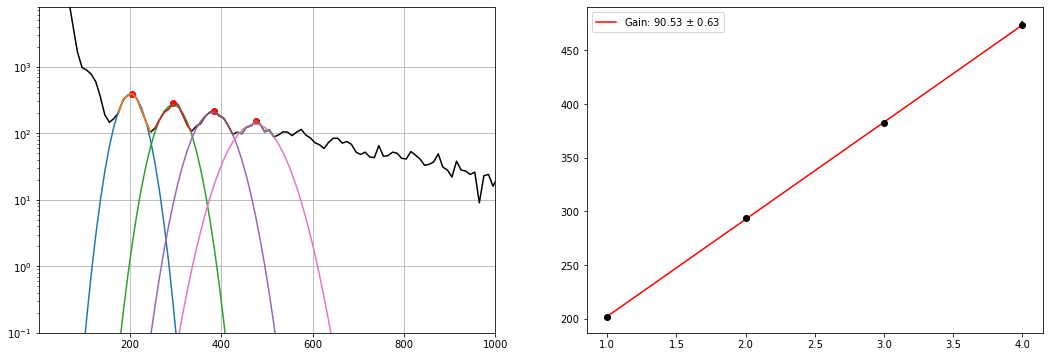

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_21.h5
Guess:  [398, 195.03571428571428, 10]
Params:  [400.536802   199.97505553  25.32540629]
Guess:  [261, 285.05219780219784, 10]
Params:  [249.64878811 291.30832196  33.37608824]
Guess:  [192, 375.06868131868134, 10]
Params:  [188.06386642 380.60663573  36.57515624]
Guess:  [160, 475.0869963369963, 10]
Params:  [144.07331783 477.30962071  54.75687996]


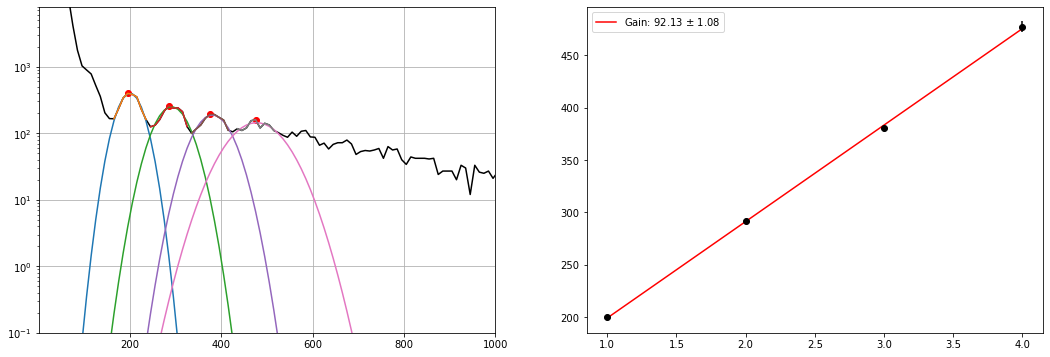

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_20.h5
Guess:  [384, 205.0375457875458, 10]
Params:  [370.60427659 202.32849375  28.18012808]
Guess:  [287, 305.0558608058608, 10]
Params:  [281.9332669  295.14683804  30.65063207]
Guess:  [220, 385.0705128205128, 10]
Params:  [207.62708943 388.25960123  36.67258481]
Guess:  [163, 485.0888278388278, 10]
Params:  [144.37010806 483.16498939  47.75754496]


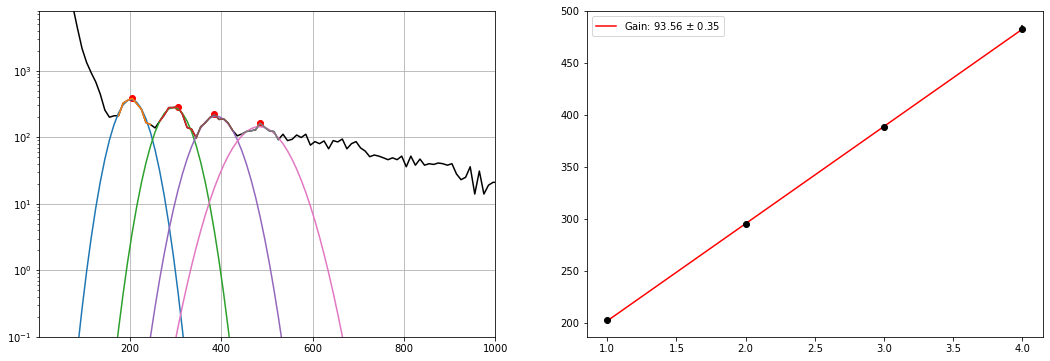

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_19.h5
Guess:  [404, 205.0375457875458, 10]
Params:  [394.8379209  202.80541108  26.34445635]
Guess:  [268, 285.05219780219784, 10]
Params:  [246.81381043 290.32712519  36.46218143]
Guess:  [204, 385.0705128205128, 10]
Params:  [189.90035629 383.79502343  39.26311991]
Guess:  [166, 475.0869963369963, 10]
Params:  [151.2180696  472.02512737  49.27205998]


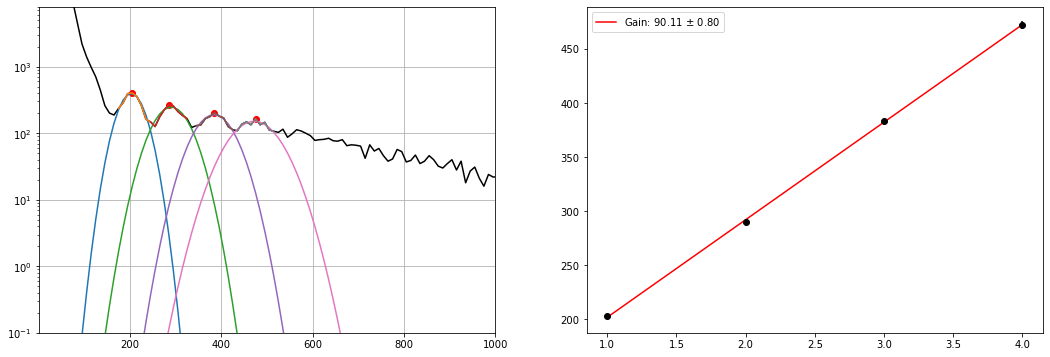

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_18.h5
Guess:  [415, 195.03571428571428, 10]
Params:  [414.68192596 201.19317272  25.78487003]
Guess:  [295, 295.0540293040293, 10]
Params:  [281.32488648 294.2791272   32.85115209]
Guess:  [228, 385.0705128205128, 10]
Params:  [206.88876908 384.01390428  37.60489269]
Guess:  [171, 475.0869963369963, 10]
Params:  [156.54456529 478.33173027  41.92836568]


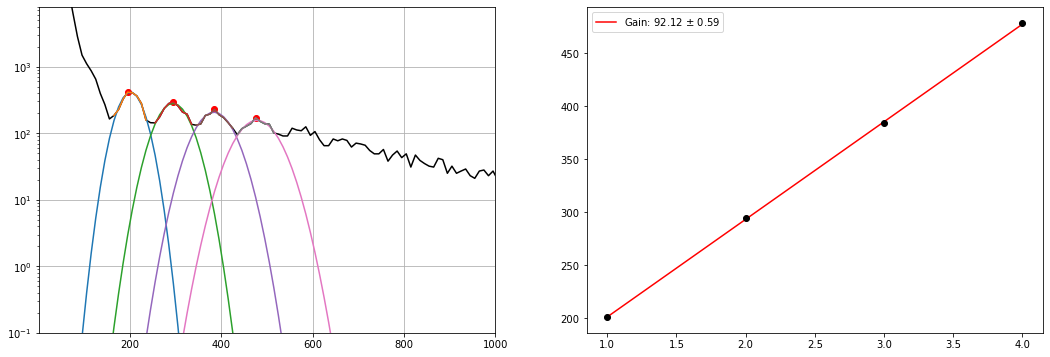

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_17.h5
Guess:  [442, 195.03571428571428, 10]
Params:  [427.46097666 200.21367051  23.47438373]
Guess:  [290, 295.0540293040293, 10]
Params:  [274.98290467 292.49430461  31.76260819]
Guess:  [220, 385.0705128205128, 10]
Params:  [208.53552237 385.15891094  35.89099272]
Guess:  [169, 475.0869963369963, 10]
Params:  [159.844039   473.53022071  44.37395258]


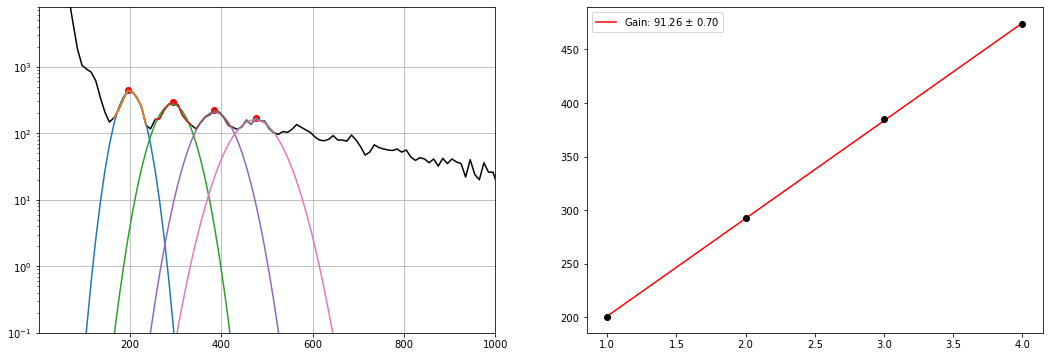

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_16.h5
Guess:  [448, 205.0375457875458, 10]
Params:  [412.78264832 201.19551448  24.77901241]
Guess:  [291, 295.0540293040293, 10]
Params:  [274.74742632 292.91102622  32.45467633]
Guess:  [221, 385.0705128205128, 10]
Params:  [204.83450879 385.45979388  34.51113748]
Guess:  [167, 465.08516483516485, 10]
Params:  [159.58434962 469.64587565  50.76391708]


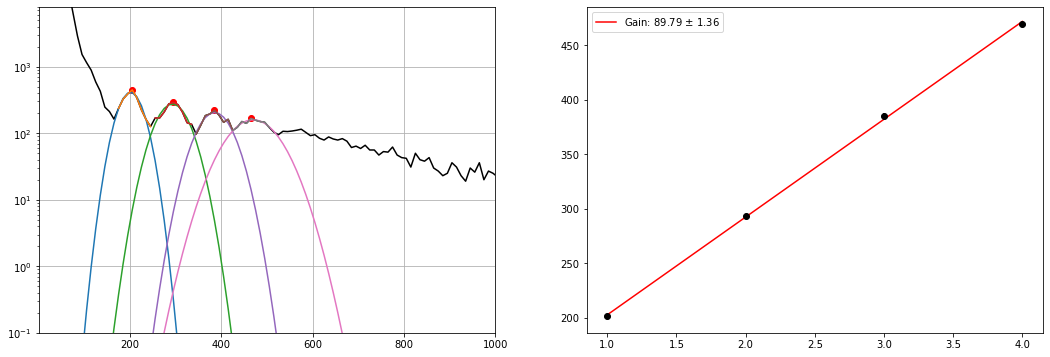

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_15.h5
Guess:  [402, 205.0375457875458, 10]
Params:  [407.33468749 201.60725456  23.65861912]
Guess:  [272, 285.05219780219784, 10]
Params:  [251.74163379 289.59912399  32.35011679]
Guess:  [210, 375.06868131868134, 10]
Params:  [200.09033479 382.33065543  41.12950419]
Guess:  [156, 485.0888278388278, 10]
Params:  [140.926148   481.15250923  47.02140361]


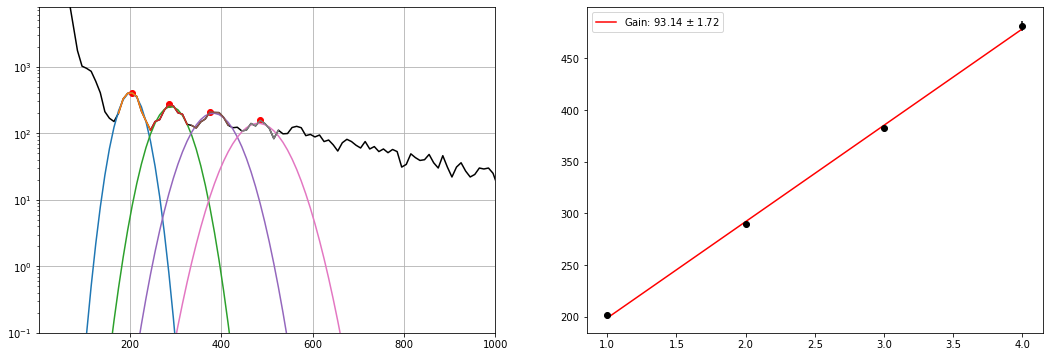

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_14.h5
Guess:  [411, 205.0375457875458, 10]
Params:  [404.72424058 200.26409331  25.90297158]
Guess:  [298, 295.0540293040293, 10]
Params:  [286.99020301 294.26535637  28.89290322]
Guess:  [205, 385.0705128205128, 10]
Params:  [204.5792134  383.95200198  35.91099671]
Guess:  [142, 475.0869963369963, 10]
Params:  [142.43438076 471.79230758  49.01336234]


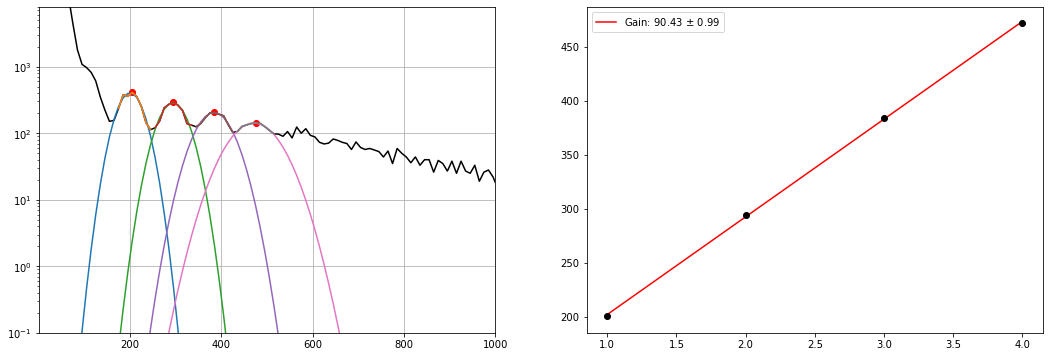

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_13.h5
Guess:  [399, 195.03571428571428, 10]
Params:  [400.33105195 201.03776562  24.01496012]
Guess:  [289, 295.0540293040293, 10]
Params:  [278.10517331 293.21853806  29.58136437]
Guess:  [204, 395.0723443223443, 10]
Params:  [194.75141341 388.8494504   41.34655902]
Guess:  [146, 475.0869963369963, 10]
Params:  [141.46221053 471.49883069  48.97136477]


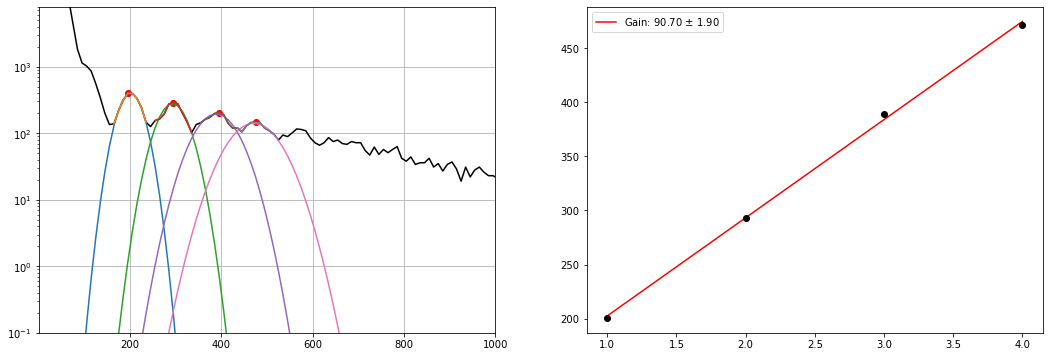

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_12.h5
Guess:  [434, 205.0375457875458, 10]
Params:  [428.51080489 201.9272399   23.57449639]
Guess:  [305, 295.0540293040293, 10]
Params:  [278.8820188  294.20683033  29.1307739 ]
Guess:  [239, 385.0705128205128, 10]
Params:  [211.5871915  385.97649858  35.04854195]
Guess:  [158, 475.0869963369963, 10]
Params:  [155.83400867 475.46085034  41.92923798]


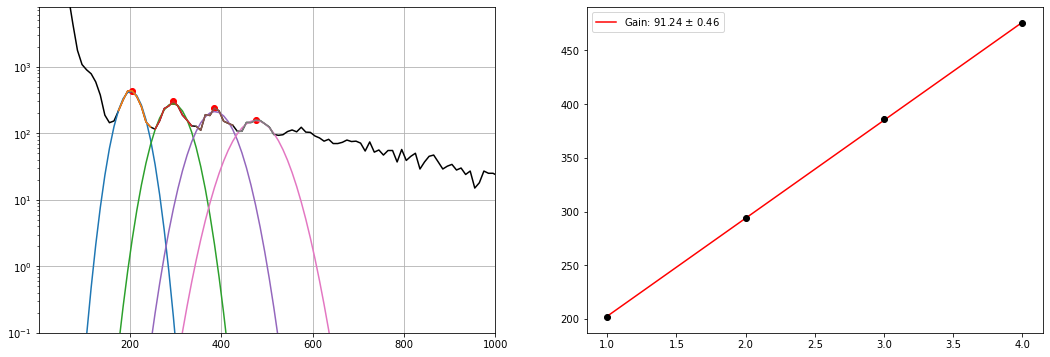

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_11.h5
Guess:  [431, 205.0375457875458, 10]
Params:  [420.00941381 202.63809017  24.49021564]
Guess:  [310, 295.0540293040293, 10]
Params:  [263.17876632 292.76445449  31.03094713]
Guess:  [213, 395.0723443223443, 10]
Params:  [201.31290453 386.41852983  37.61519598]
Guess:  [162, 485.0888278388278, 10]
Params:  [143.29954334 478.28702875  51.73296106]


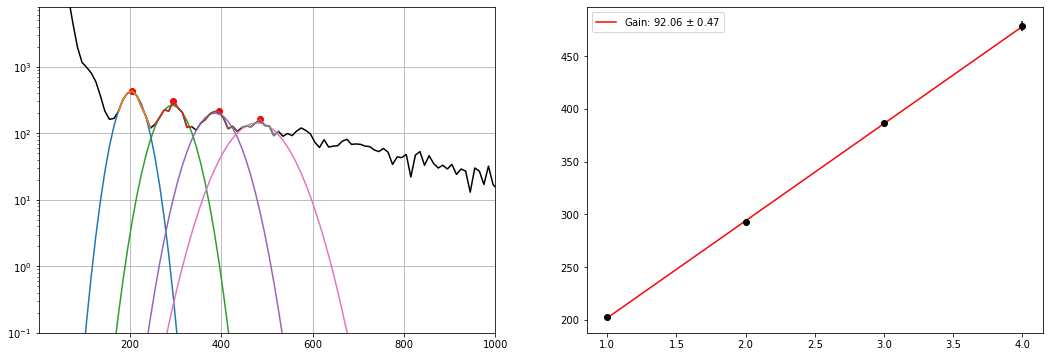

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_10.h5
Guess:  [433, 205.0375457875458, 10]
Params:  [414.09263559 201.44541079  25.06528048]
Guess:  [265, 295.0540293040293, 10]
Params:  [252.24999647 293.45217667  33.36837707]
Guess:  [194, 385.0705128205128, 10]
Params:  [183.41837617 382.84103418  39.34610778]
Guess:  [148, 475.0869963369963, 10]
Params:  [141.54639991 474.5901385   50.53683339]


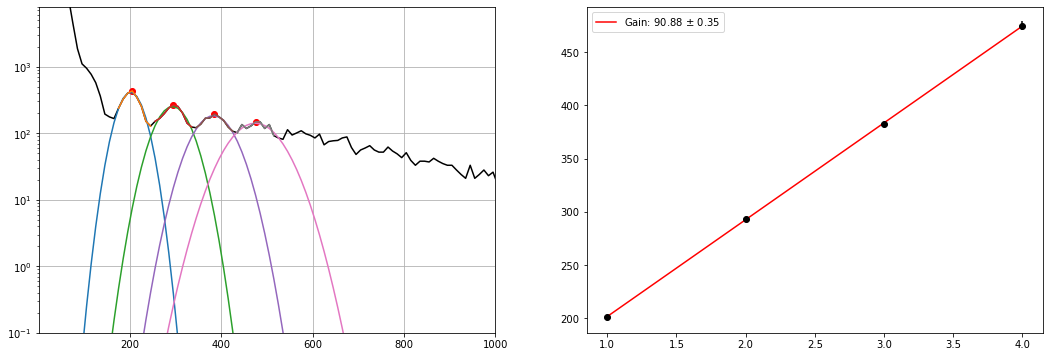

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_9.h5
Guess:  [445, 205.0375457875458, 10]
Params:  [423.02304084 201.49948921  23.61332266]
Guess:  [299, 295.0540293040293, 10]
Params:  [276.4368984  291.91372874  29.84624081]
Guess:  [215, 385.0705128205128, 10]
Params:  [206.08463367 382.70238731  35.96999685]
Guess:  [158, 455.08333333333337, 10]
Params:  [133.92539773 468.16745135 136.78382246]


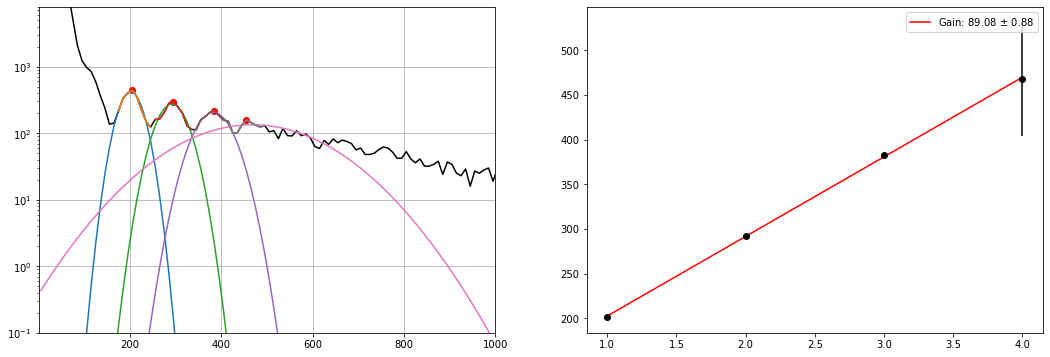

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_8.h5
Guess:  [437, 205.0375457875458, 10]
Params:  [419.98641154 202.68225364  23.773593  ]
Guess:  [286, 305.0558608058608, 10]
Params:  [257.81651061 295.78727669  33.6430194 ]
Guess:  [208, 395.0723443223443, 10]
Params:  [190.41545803 388.72275475  38.87425613]
Guess:  [147, 475.0869963369963, 10]
Params:  [147.31767901 473.39046887  43.65627352]


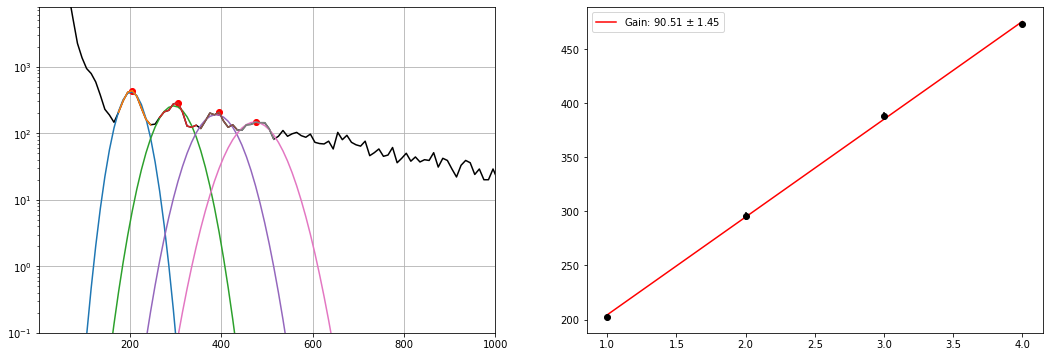

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_7.h5
Guess:  [405, 205.0375457875458, 10]
Params:  [392.55315319 202.10472241  25.48047704]
Guess:  [291, 295.0540293040293, 10]
Params:  [275.3076796  294.81173911  29.20091597]
Guess:  [211, 375.06868131868134, 10]
Params:  [195.90293185 383.81187968  37.64519357]
Guess:  [144, 485.0888278388278, 10]
Params:  [141.81647029 472.80829245  48.00109254]


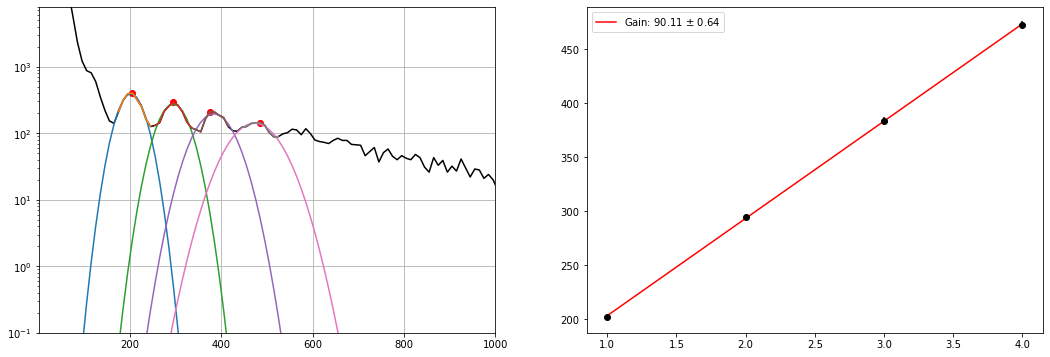

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_6.h5
Guess:  [379, 205.0375457875458, 10]
Params:  [379.83603187 202.54591865  25.89086268]
Guess:  [262, 295.0540293040293, 10]
Params:  [257.5178895  293.21542826  28.87913834]
Guess:  [216, 385.0705128205128, 10]
Params:  [189.87740457 385.63205687  37.95551177]
Guess:  [144, 485.0888278388278, 10]
Params:  [139.12470649 478.46078907  41.35223166]


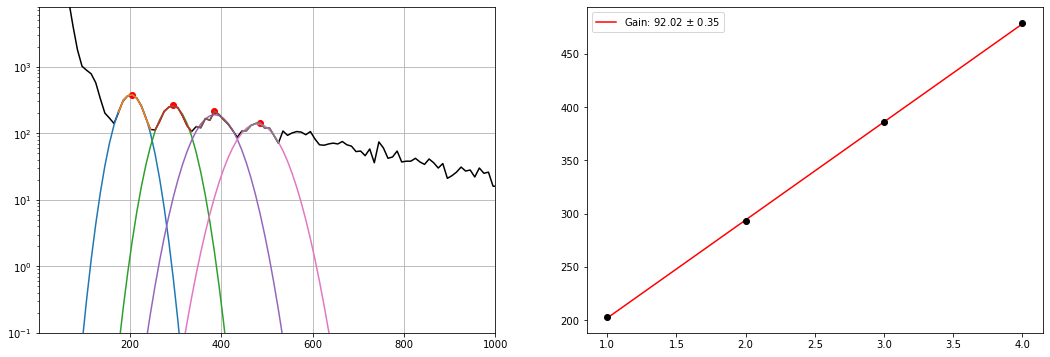

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_5.h5
Guess:  [390, 205.0375457875458, 10]
Params:  [379.27796945 200.68377447  25.04421941]
Guess:  [283, 295.0540293040293, 10]
Params:  [274.45057944 294.245787    27.63054124]
Guess:  [217, 385.0705128205128, 10]
Params:  [196.58425107 384.08312055  37.59516132]
Guess:  [149, 465.08516483516485, 10]
Params:  [140.83412775 467.60678211  49.82967258]


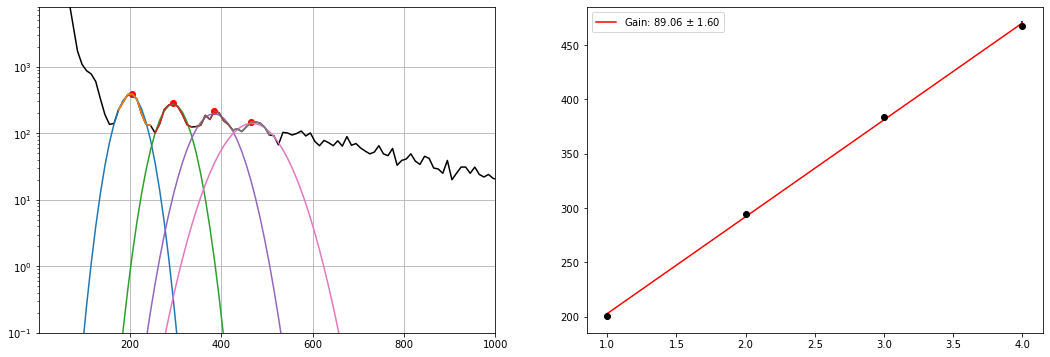

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_4.h5
Guess:  [399, 195.03571428571428, 10]
Params:  [392.26164505 200.91058296  24.05077201]
Guess:  [274, 285.05219780219784, 10]
Params:  [268.90545371 290.90027409  28.23423566]
Guess:  [203, 375.06868131868134, 10]
Params:  [194.08957606 381.35917557  37.66607631]
Guess:  [144, 485.0888278388278, 10]
Params:  [143.27392314 474.49649544  47.96858599]


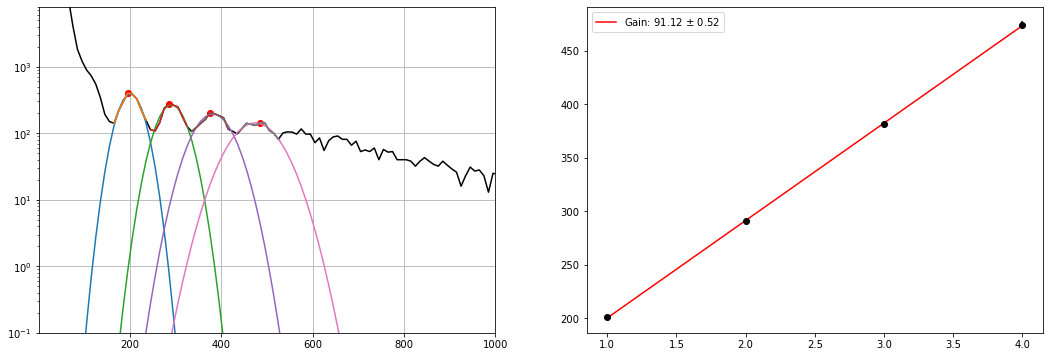

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_3.h5
Guess:  [429, 205.0375457875458, 10]
Params:  [413.27502392 200.82198644  24.13329984]
Guess:  [278, 295.0540293040293, 10]
Params:  [269.83433015 292.02548052  31.85278057]
Guess:  [207, 375.06868131868134, 10]
Params:  [199.87625996 384.61260202  39.69280919]
Guess:  [159, 475.0869963369963, 10]
Params:  [150.24667077 468.72349168  43.77639338]


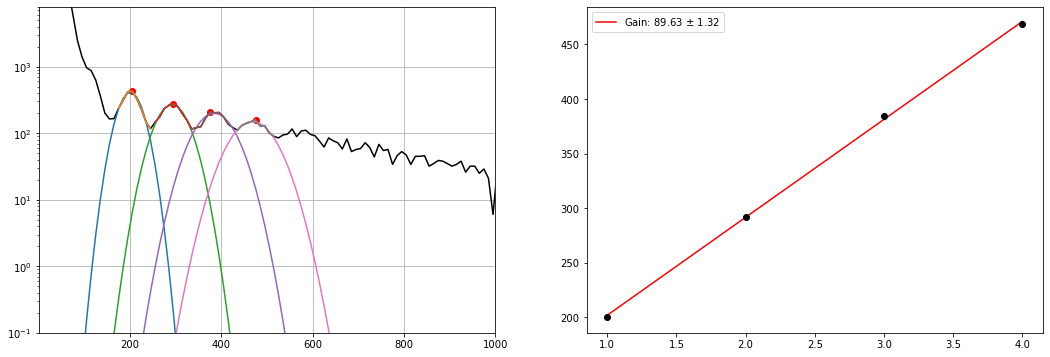

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_2.h5
Guess:  [416, 195.03571428571428, 10]
Params:  [405.26337957 200.9354829   24.93349518]
Guess:  [279, 285.05219780219784, 10]
Params:  [266.64353815 291.40511602  33.26244731]
Guess:  [238, 375.06868131868134, 10]
Params:  [207.69268717 383.29633644  38.90925665]
Guess:  [158, 475.0869963369963, 10]
Params:  [149.73604124 474.34348069  52.77820158]


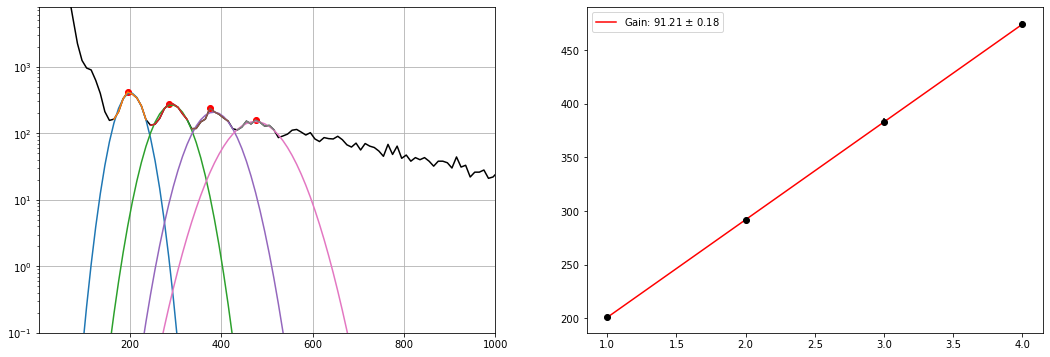

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_1.h5
Guess:  [364, 205.0375457875458, 10]
Params:  [357.97275539 202.26295894  31.84131758]
Guess:  [257, 305.0558608058608, 10]
Params:  [247.66988617 296.11641782  37.62384207]
Guess:  [199, 385.0705128205128, 10]
Params:  [187.29148712 382.45835166  46.79881416]
Guess:  [145, 475.0869963369963, 10]
Params:  [137.81024965 471.8868444   60.98216382]


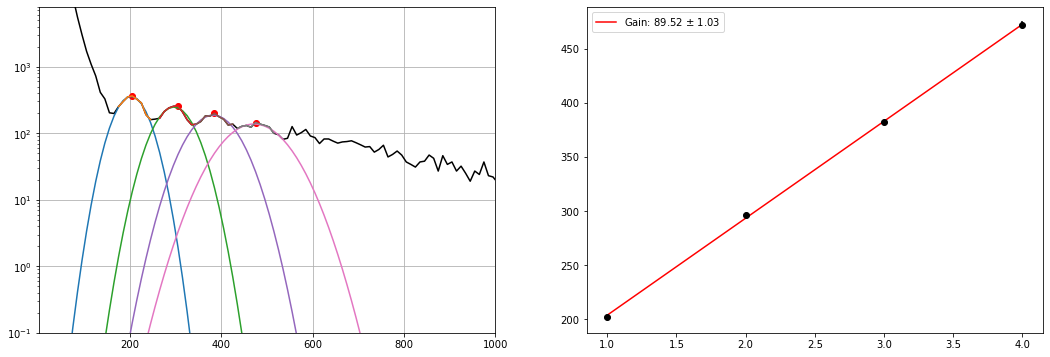

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_405_0.h5
Guess:  [416, 195.03571428571428, 10]
Params:  [387.30054543 198.68188747  27.56919365]
Guess:  [296, 295.0540293040293, 10]
Params:  [271.79408463 293.61078096  31.43624212]
Guess:  [240, 385.0705128205128, 10]
Params:  [202.6836921  383.83095568  37.3675349 ]
Guess:  [159, 485.0888278388278, 10]
Params:  [155.78985814 476.87658595  40.72218997]


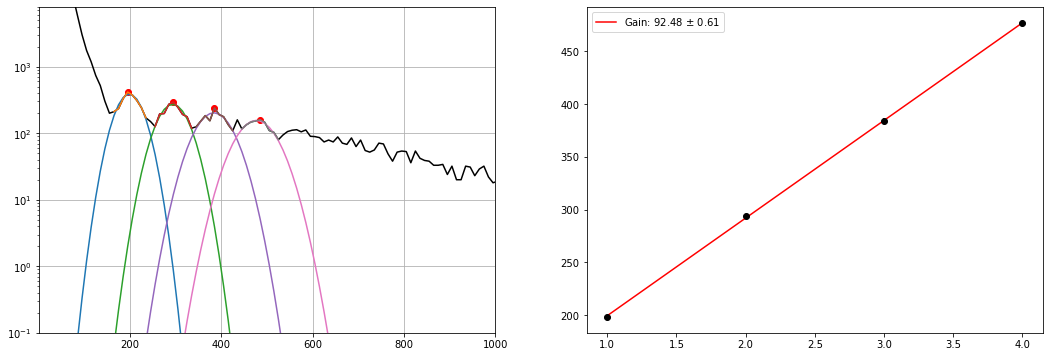

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_33.h5
Guess:  [255, 205.0375457875458, 10]
Params:  [236.28434148 201.6334885   28.49386983]
Guess:  [134, 295.0540293040293, 10]
Params:  [125.62121273 293.97706233  27.79172942]
Guess:  [75, 395.0723443223443, 10]
Params:  [ 74.81997909 394.2396501   39.68751965]


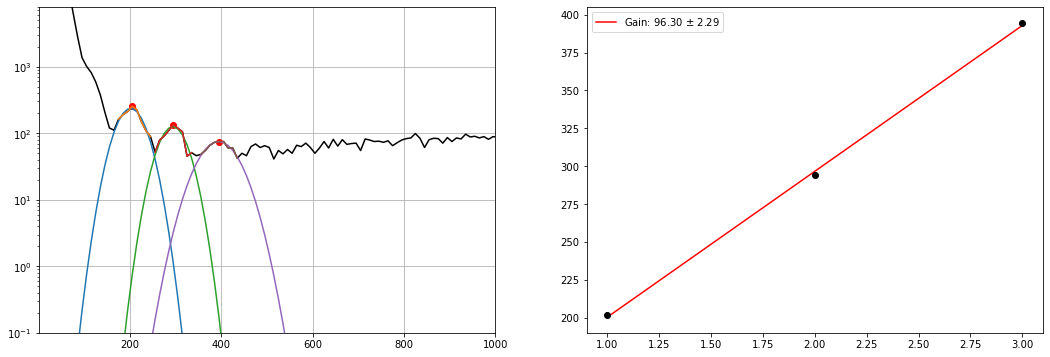

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_32.h5
Guess:  [245, 205.0375457875458, 10]
Params:  [235.32316801 202.25632174  24.02248955]
Guess:  [119, 295.0540293040293, 10]
Params:  [121.60696427 297.84467643  29.45622748]
Guess:  [78, 385.0705128205128, 10]
Params:  [ 75.231262   390.95232987  32.05220441]


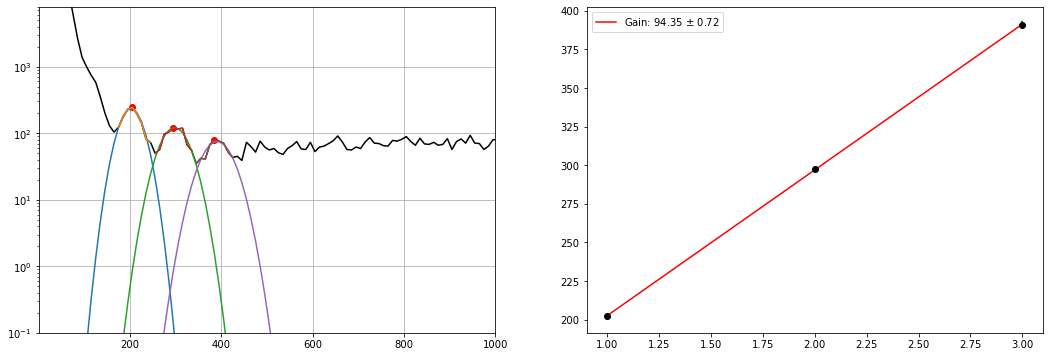

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_31.h5
Guess:  [247, 205.0375457875458, 10]
Params:  [224.60431671 203.01951016  23.52530206]
Guess:  [107, 295.0540293040293, 10]
Params:  [103.70728137 298.23723248  34.48380889]
Guess:  [86, 395.0723443223443, 10]
Params:  [ 74.16960506 395.16521094  34.49710253]


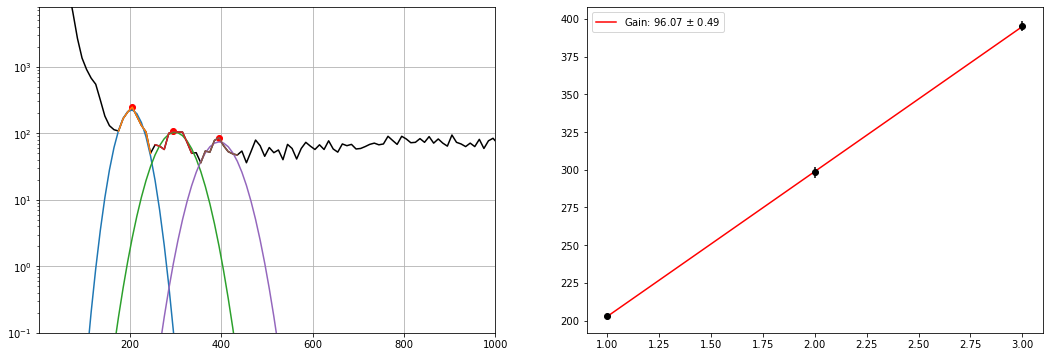

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_30.h5
Guess:  [247, 205.0375457875458, 10]
Params:  [235.85691343 204.4999064   23.85530284]
Guess:  [134, 295.0540293040293, 10]
Params:  [112.21063407 294.22627556  29.14848808]
Guess:  [71, 385.0705128205128, 10]
Params:  [ 65.98053432 391.58591738  41.04861224]


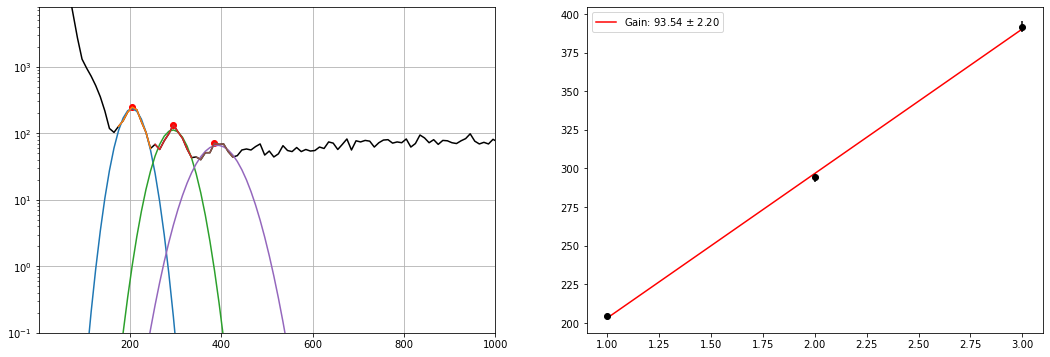

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_29.h5
Guess:  [237, 205.0375457875458, 10]
Params:  [231.80328771 203.19754696  25.30388321]
Guess:  [130, 295.0540293040293, 10]
Params:  [114.87430743 299.50883169  30.54736825]
Guess:  [72, 385.0705128205128, 10]
Params:  [ 67.38888146 392.83149432  43.73663339]


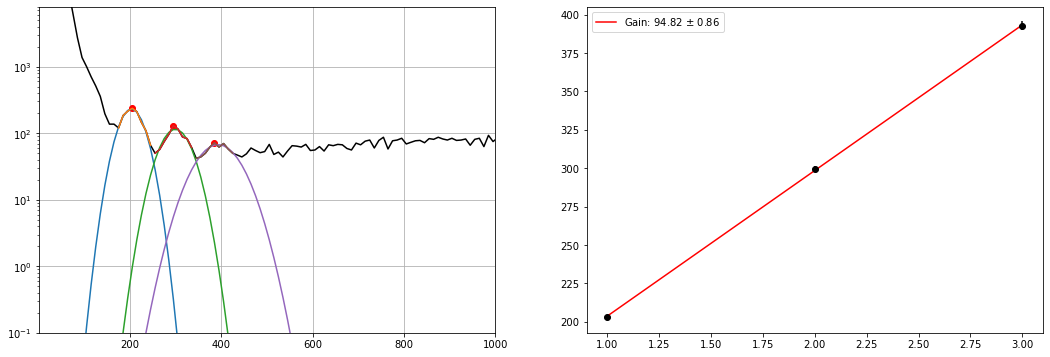

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_28.h5
Guess:  [279, 205.0375457875458, 10]
Params:  [262.72837605 202.81656115  23.2096323 ]
Guess:  [113, 295.0540293040293, 10]
Params:  [106.92274265 296.69081073  35.78585596]
Guess:  [90, 395.0723443223443, 10]
Params:  [ 76.39335804 390.22244462  30.55696519]


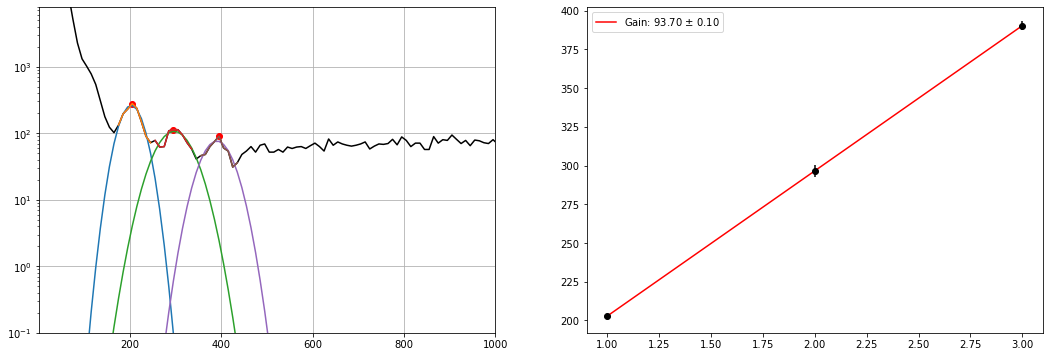

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_27.h5
Guess:  [252, 195.03571428571428, 10]
Params:  [239.89239718 199.36255164  23.17640523]
Guess:  [116, 295.0540293040293, 10]
Params:  [111.90420534 296.12541944  28.52269746]
Guess:  [79, 395.0723443223443, 10]
Params:  [ 70.95977802 399.13919313  43.77002634]


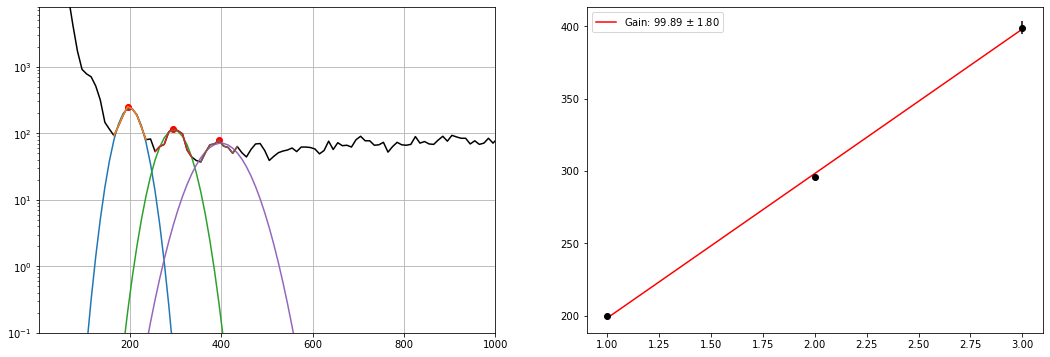

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_26.h5
Guess:  [232, 195.03571428571428, 10]
Params:  [231.95462692 201.37674923  27.86545455]
Guess:  [117, 285.05219780219784, 10]
Params:  [ 97.31512125 289.78909732  42.70194362]
Guess:  [84, 395.0723443223443, 10]
Params:  [ 73.25503971 389.89419631  44.69068738]


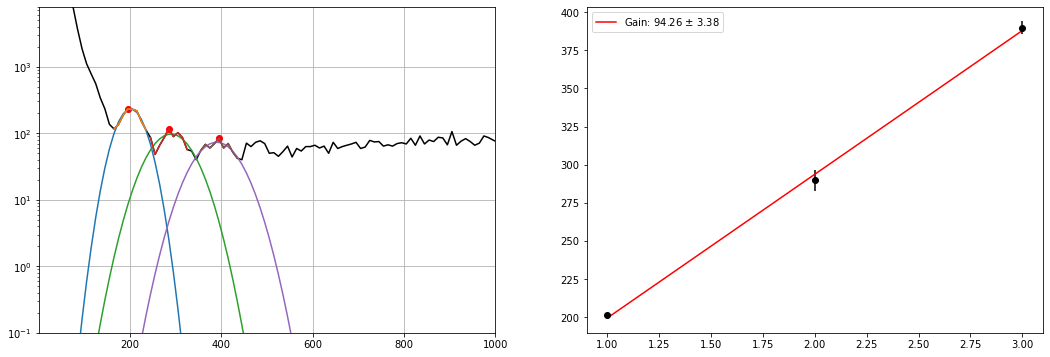

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_25.h5
Guess:  [231, 205.0375457875458, 10]
Params:  [213.83520017 203.87174713  26.23887444]
Guess:  [131, 305.0558608058608, 10]
Params:  [120.13921677 298.17358753  29.40548572]
Guess:  [79, 395.0723443223443, 10]
Params:  [ 76.06558735 395.38593311  34.60504888]


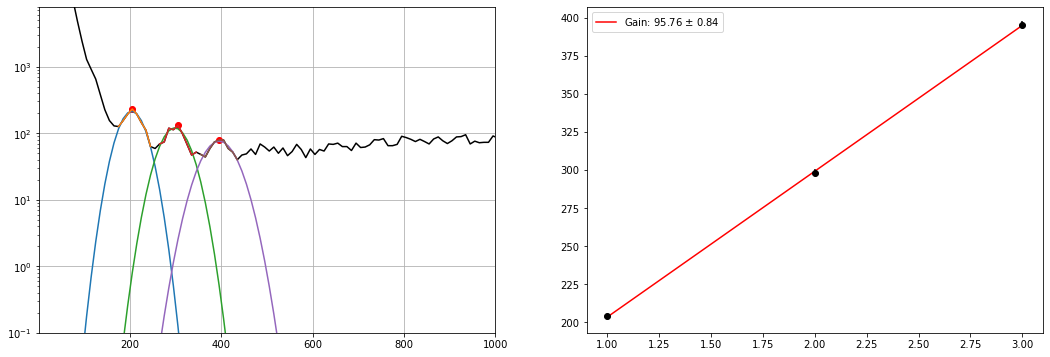

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_24.h5
Guess:  [244, 205.0375457875458, 10]
Params:  [241.8135773  202.94031536  24.22082642]
Guess:  [118, 295.0540293040293, 10]
Params:  [113.02129176 295.69479134  31.22701397]
Guess:  [91, 395.0723443223443, 10]
Params:  [ 77.66955761 393.51467153  34.82016377]


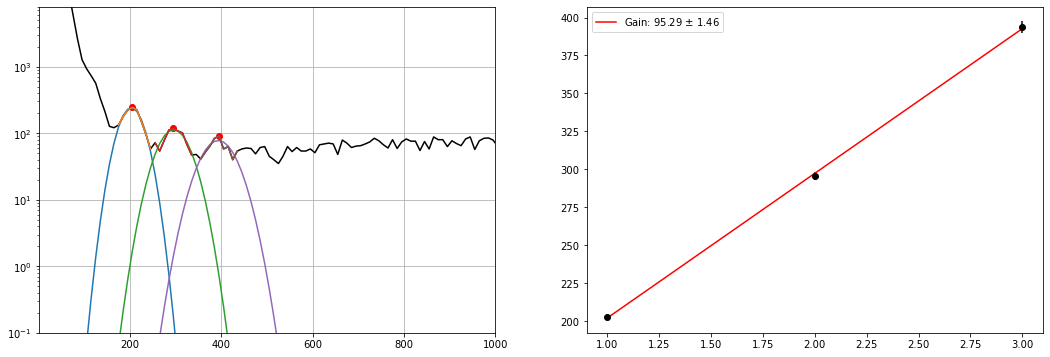

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_23.h5
Guess:  [275, 195.03571428571428, 10]
Params:  [258.565201   200.41179014  27.29684806]
Guess:  [124, 305.0558608058608, 10]
Params:  [119.59950609 298.15829721  32.35428024]
Guess:  [95, 395.0723443223443, 10]
Params:  [ 82.87968741 386.59231691  38.71654882]


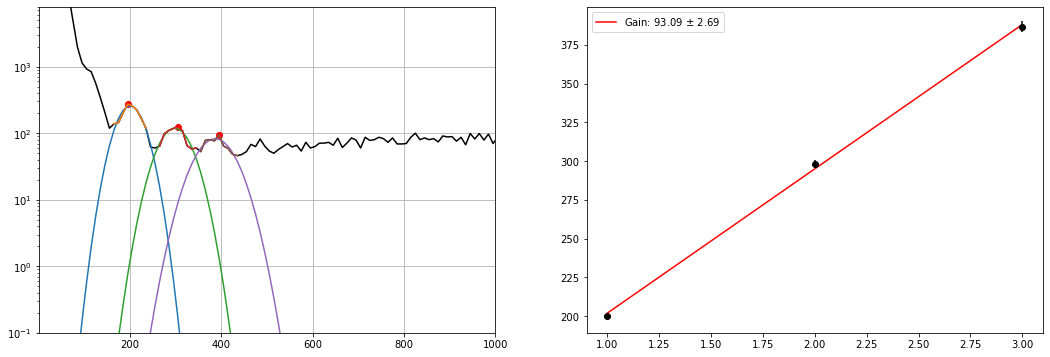

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_22.h5
Guess:  [230, 205.0375457875458, 10]
Params:  [239.00737827 199.9847052   23.50417473]
Guess:  [129, 305.0558608058608, 10]
Params:  [110.2629609  297.99372136  30.70333918]
Guess:  [83, 395.0723443223443, 10]
Params:  [ 74.03095772 391.75329512  36.29474119]


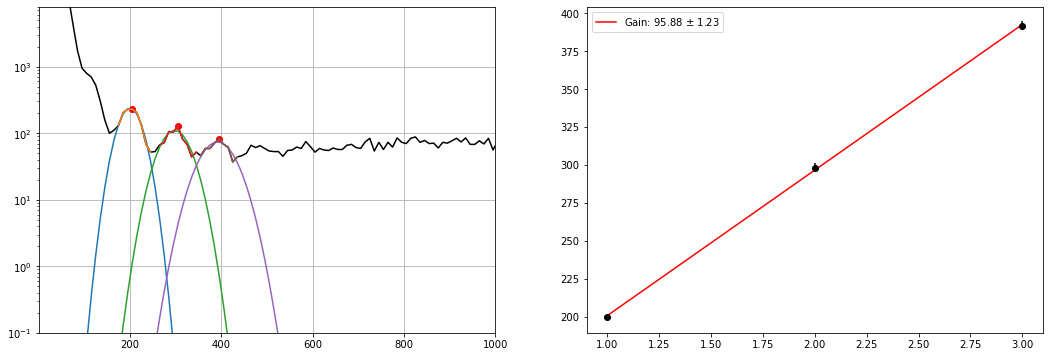

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_21.h5
Guess:  [264, 205.0375457875458, 10]
Params:  [247.20767854 202.63587279  24.58854471]
Guess:  [124, 295.0540293040293, 10]
Params:  [114.54605524 292.49151387  29.35467491]
Guess:  [100, 385.0705128205128, 10]
Params:  [ 83.51395286 386.55964588  30.11630023]


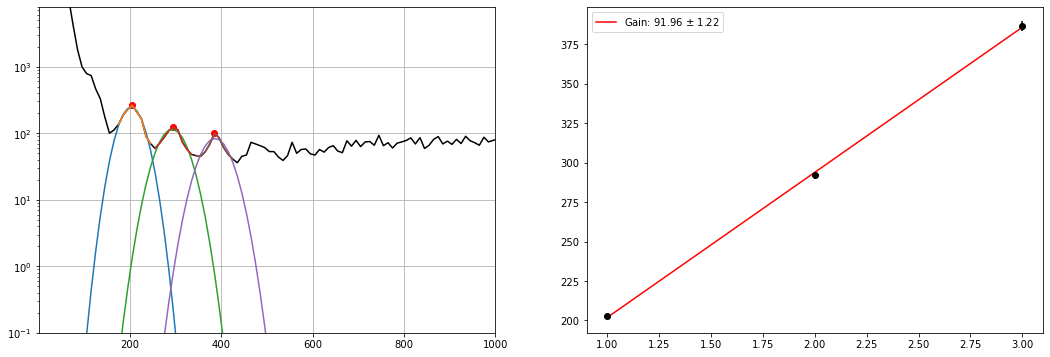

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_20.h5
Guess:  [244, 195.03571428571428, 10]
Params:  [235.44624663 202.55501108  27.98879213]
Guess:  [121, 295.0540293040293, 10]
Params:  [116.58102864 299.1539134   32.91904476]
Guess:  [78, 385.0705128205128, 10]
Params:  [ 70.9515058  394.61118345  40.41819765]


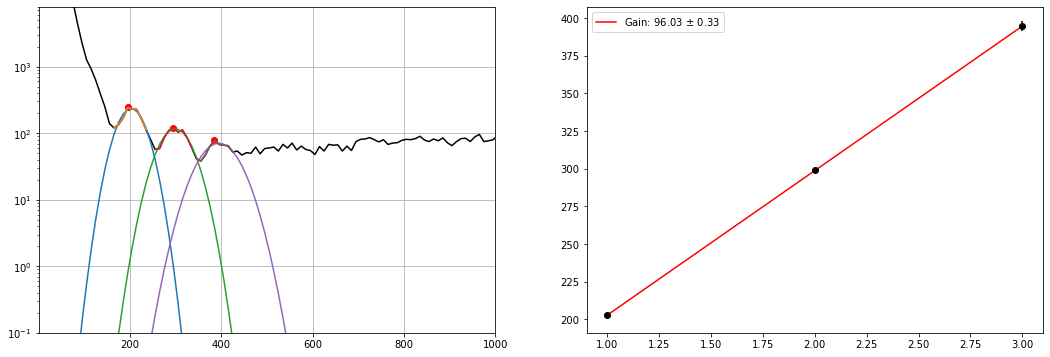

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_19.h5
Guess:  [223, 195.03571428571428, 10]
Params:  [218.22936036 200.82858914  29.82569396]
Guess:  [113, 305.0558608058608, 10]
Params:  [108.74990486 297.45451431  35.19968021]
Guess:  [77, 385.0705128205128, 10]
Params:  [ 67.28856316 384.91534676  40.43025706]


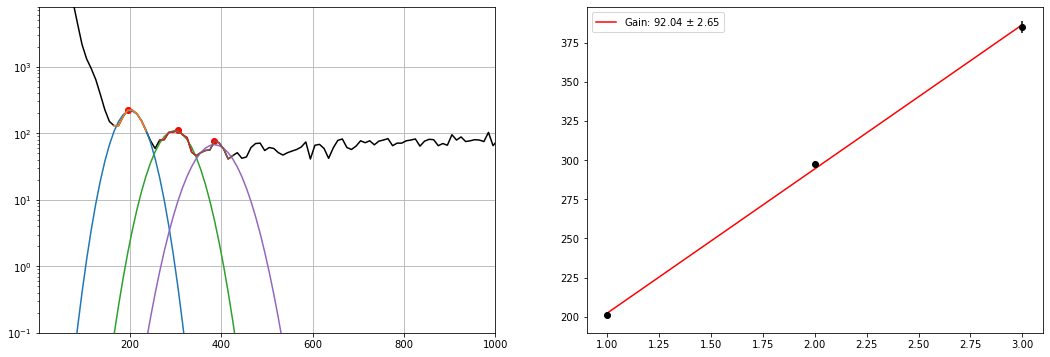

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_18.h5
Guess:  [258, 205.0375457875458, 10]
Params:  [243.65793481 201.94733501  24.35131907]
Guess:  [118, 295.0540293040293, 10]
Params:  [114.1870288  296.04520987  30.40457717]
Guess:  [77, 395.0723443223443, 10]
Params:  [ 72.65684998 387.59855776  39.43419655]


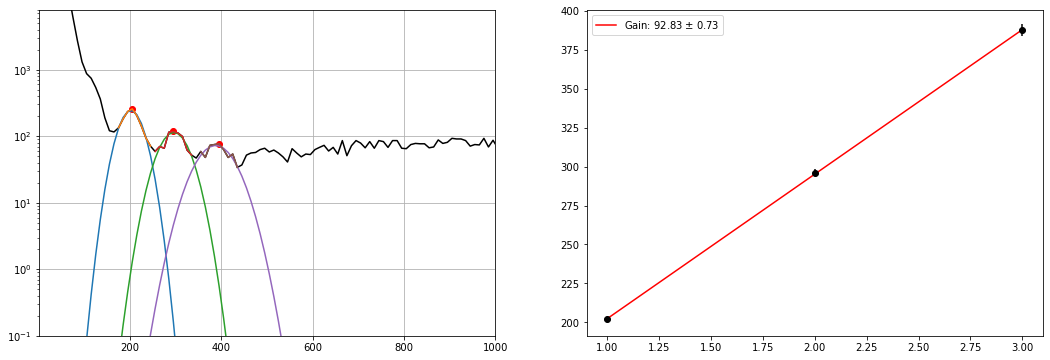

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_17.h5
Guess:  [251, 205.0375457875458, 10]
Params:  [248.73530033 203.90390729  24.02572468]
Guess:  [123, 295.0540293040293, 10]
Params:  [116.65227031 298.11351841  30.83019264]
Guess:  [83, 395.0723443223443, 10]
Params:  [ 76.08740647 392.63163907  37.27455329]


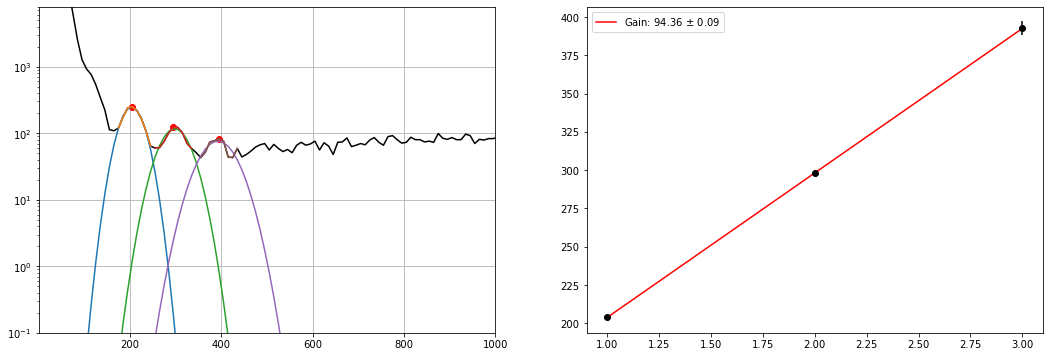

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_16.h5
Guess:  [284, 205.0375457875458, 10]
Params:  [264.02076176 204.36568518  22.43325585]
Guess:  [121, 285.05219780219784, 10]
Params:  [112.03398119 293.84673951  31.3912937 ]
Guess:  [78, 375.06868131868134, 10]
Params:  [ 67.90664462 387.34038311  41.69925093]


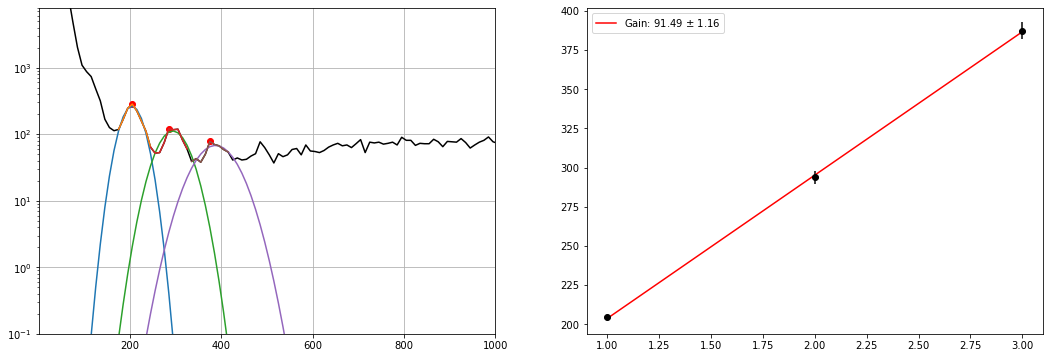

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_15.h5
Guess:  [264, 205.0375457875458, 10]
Params:  [247.44647138 201.73547581  24.68576938]
Guess:  [117, 295.0540293040293, 10]
Params:  [112.0676364  295.36878073  29.75855881]
Guess:  [76, 395.0723443223443, 10]
Params:  [ 74.3690728  396.04149666  38.98418495]


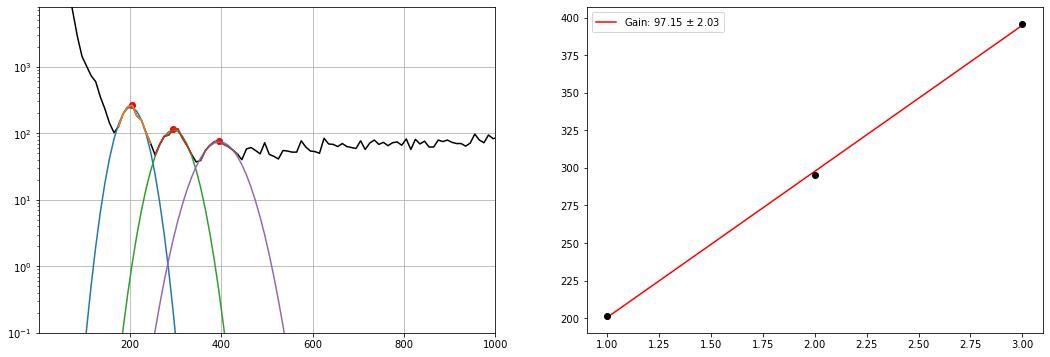

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_14.h5
Guess:  [247, 205.0375457875458, 10]
Params:  [233.79826085 203.68115228  23.71144679]
Guess:  [126, 285.05219780219784, 10]
Params:  [111.93450946 295.11274918  33.63030219]
Guess:  [77, 405.0741758241758, 10]
Params:  [ 72.99105748 392.49883623  46.77578292]


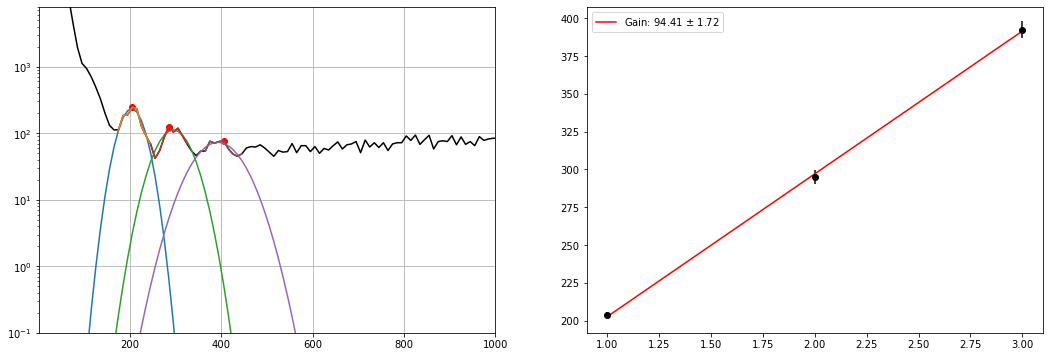

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_13.h5
Guess:  [237, 205.0375457875458, 10]
Params:  [237.14637068 202.94553297  24.77989469]
Guess:  [129, 295.0540293040293, 10]
Params:  [121.00559716 294.59390602  28.91192427]
Guess:  [76, 385.0705128205128, 10]
Params:  [ 72.94775617 388.56989011  42.32164452]


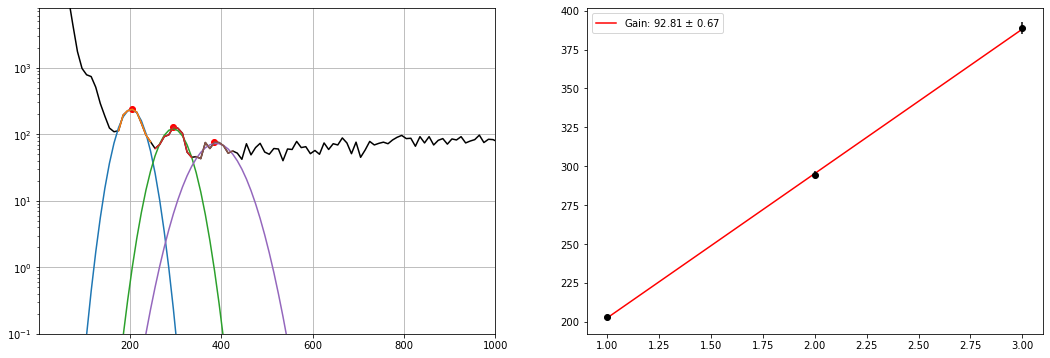

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_12.h5
Guess:  [262, 205.0375457875458, 10]
Params:  [263.44119063 202.60039091  22.82243048]
Guess:  [116, 305.0558608058608, 10]
Params:  [110.42541363 297.97236048  32.85980938]
Guess:  [84, 395.0723443223443, 10]
Params:  [ 74.49814344 395.65938569  35.86062295]


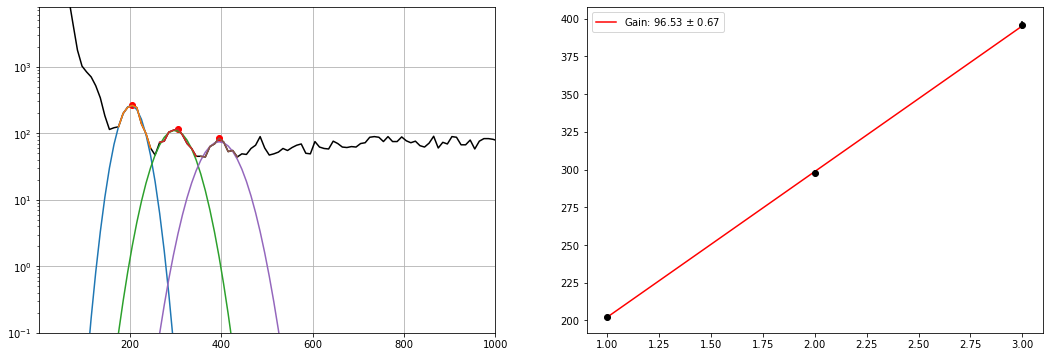

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_11.h5
Guess:  [268, 205.0375457875458, 10]
Params:  [260.36062772 202.80550269  23.38056035]
Guess:  [134, 295.0540293040293, 10]
Params:  [128.63711432 294.745862    27.31636343]
Guess:  [86, 395.0723443223443, 10]
Params:  [ 74.69547428 391.17620236  39.34579683]


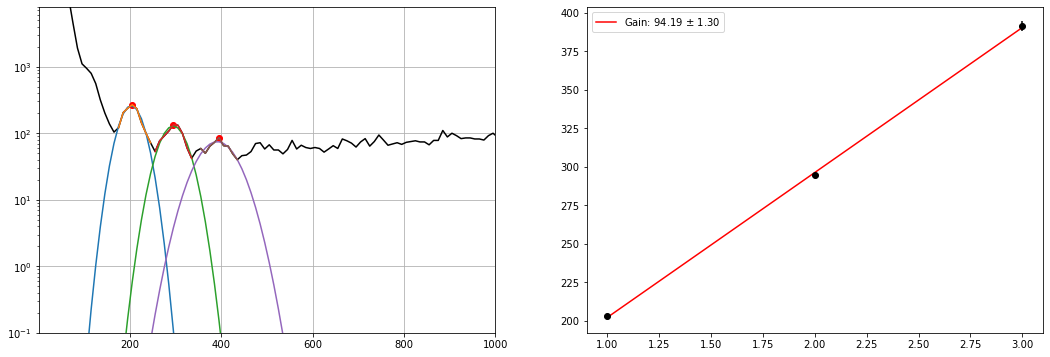

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_10.h5
Guess:  [250, 205.0375457875458, 10]
Params:  [239.71506936 201.18312345  24.53621869]
Guess:  [115, 295.0540293040293, 10]
Params:  [108.97607587 297.56742655  31.79497491]
Guess:  [92, 395.0723443223443, 10]
Params:  [ 84.30711422 392.44399608  31.04092291]


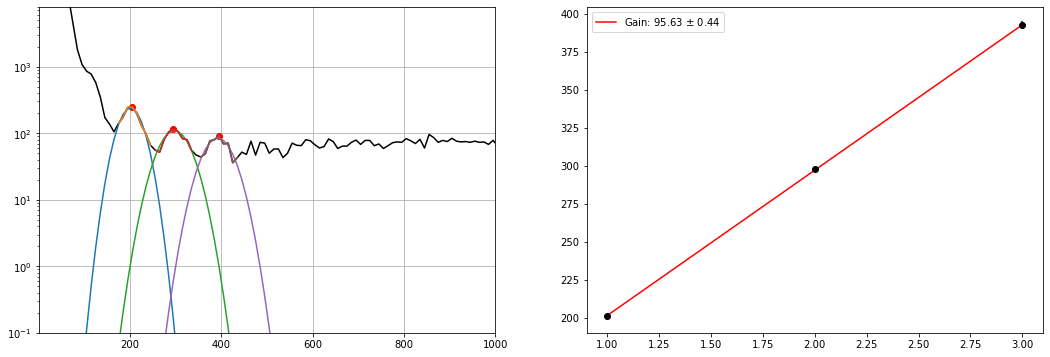

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_9.h5
Guess:  [260, 195.03571428571428, 10]
Params:  [252.44115247 201.76666662  25.80843741]
Guess:  [145, 295.0540293040293, 10]
Params:  [117.41811351 294.72334462  29.06073148]
Guess:  [100, 395.0723443223443, 10]
Params:  [ 91.00018962 390.97689659  31.13442168]


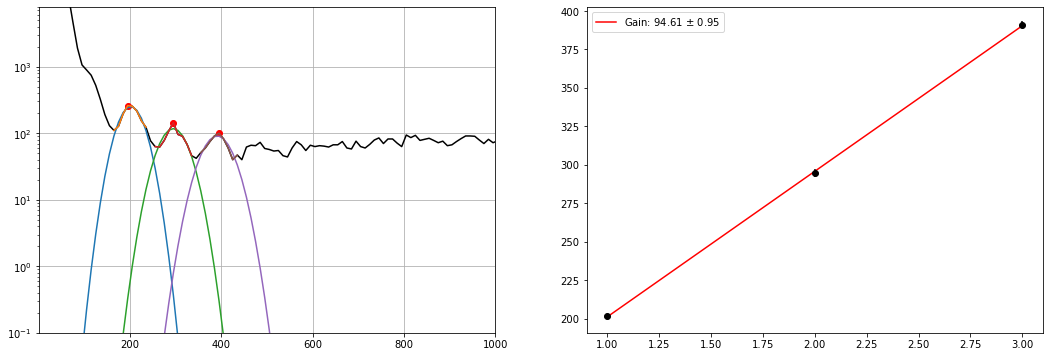

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_8.h5
Guess:  [242, 195.03571428571428, 10]
Params:  [239.71333845 201.96977392  26.8009966 ]
Guess:  [120, 295.0540293040293, 10]
Params:  [118.23380739 297.56424165  30.30736989]
Guess:  [99, 395.0723443223443, 10]
Params:  [ 75.28167181 387.40121212  41.94677204]


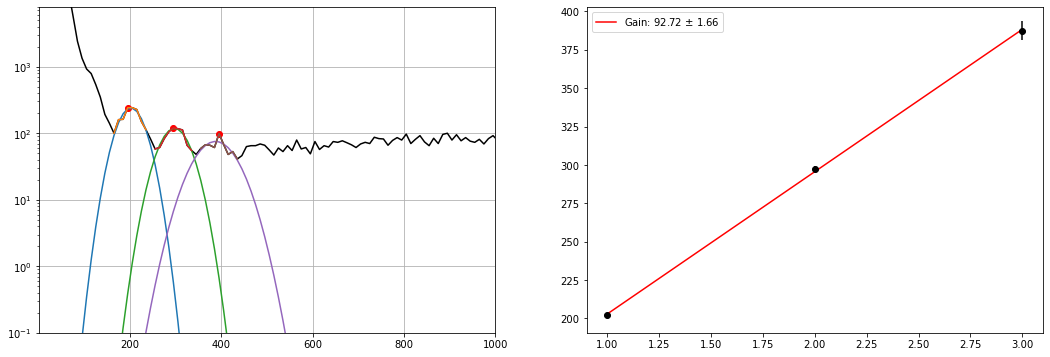

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_7.h5
Guess:  [248, 205.0375457875458, 10]
Params:  [242.20066833 201.30987956  24.77023441]
Guess:  [130, 295.0540293040293, 10]
Params:  [114.1125652  295.37312372  27.54709906]
Guess:  [88, 395.0723443223443, 10]
Params:  [ 72.10878957 388.94631208  40.8215665 ]


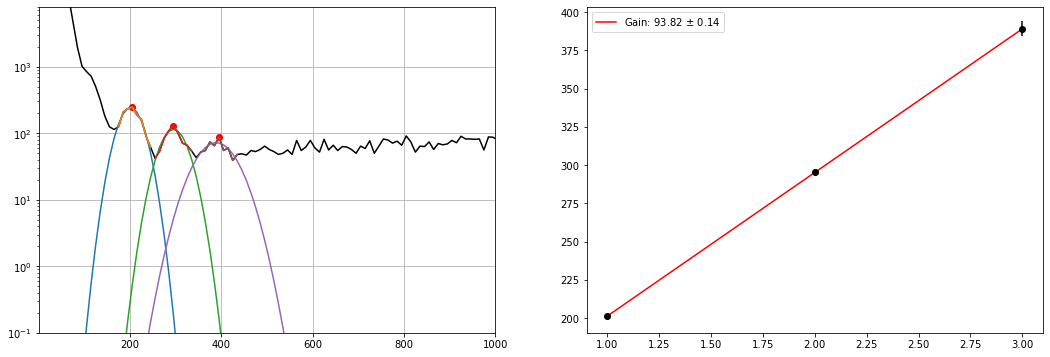

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_6.h5
Guess:  [259, 205.0375457875458, 10]
Params:  [242.80329987 201.42539253  24.18028824]
Guess:  [126, 295.0540293040293, 10]
Params:  [118.38553156 295.33904178  26.7330872 ]
Guess:  [75, 395.0723443223443, 10]
Params:  [ 73.19362433 390.67726462  37.35824309]


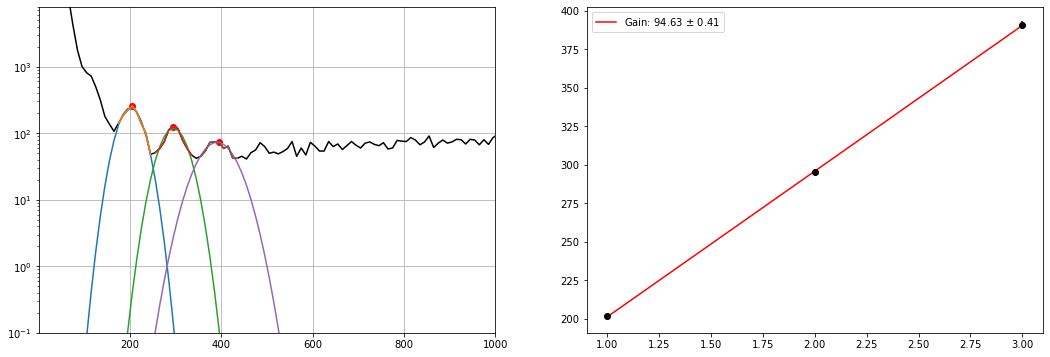

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_5.h5
Guess:  [248, 205.0375457875458, 10]
Params:  [239.02219559 201.57483533  24.30780716]
Guess:  [110, 295.0540293040293, 10]
Params:  [104.0458894  296.24789165  34.99901926]
Guess:  [84, 395.0723443223443, 10]
Params:  [ 68.42822629 396.38786116  51.37632969]


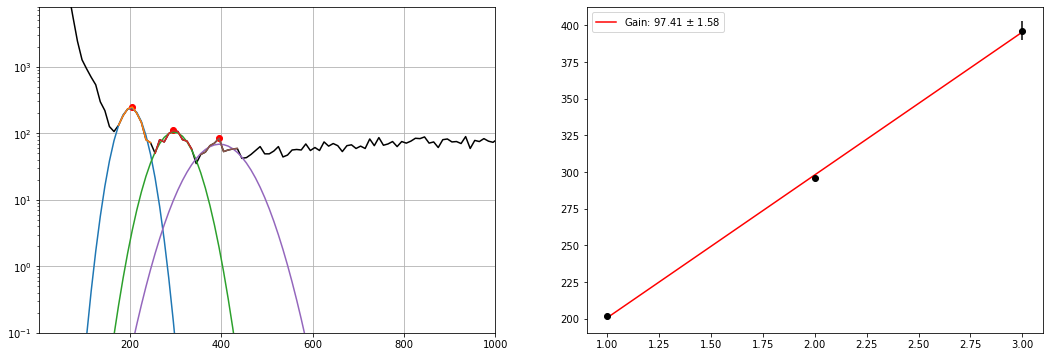

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_4.h5
Guess:  [253, 205.0375457875458, 10]
Params:  [241.200013   202.69993708  23.01341777]
Guess:  [136, 295.0540293040293, 10]
Params:  [123.98765823 294.0126931   24.72112459]
Guess:  [79, 395.0723443223443, 10]
Params:  [ 69.75313602 390.6611939   42.66561297]


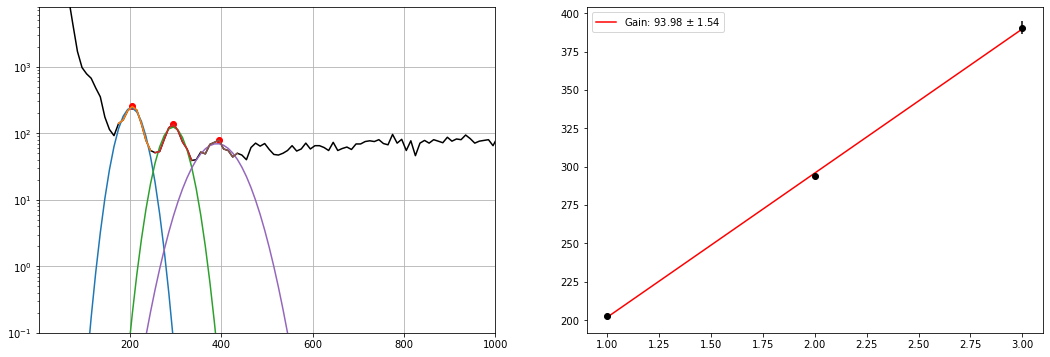

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_3.h5
Guess:  [241, 195.03571428571428, 10]
Params:  [229.70313919 202.64708061  24.02840585]
Guess:  [128, 295.0540293040293, 10]
Params:  [110.64436137 298.63695151  26.77980751]
Guess:  [80, 395.0723443223443, 10]
Params:  [ 71.70690141 393.19752308  36.21728916]


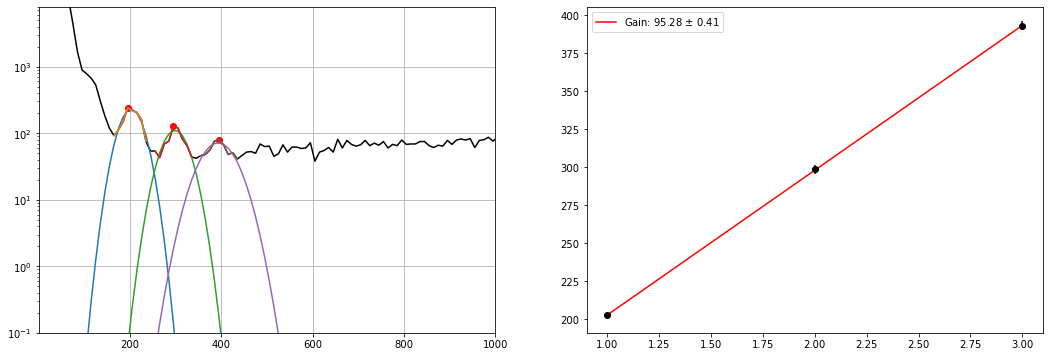

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_2.h5
Guess:  [275, 205.0375457875458, 10]
Params:  [273.41674006 203.16385581  23.81585502]
Guess:  [120, 305.0558608058608, 10]
Params:  [123.11473738 297.15249631  30.29770932]
Guess:  [86, 415.07600732600736, 10]
Params:  [ 76.6641952  394.42863062  52.28983102]


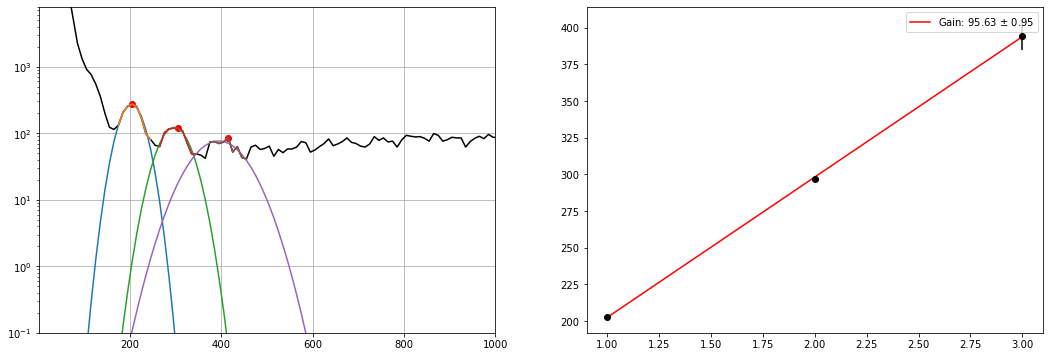

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_1.h5
Guess:  [234, 205.0375457875458, 10]
Params:  [224.58924059 204.88653513  26.88298764]
Guess:  [104, 305.0558608058608, 10]
Params:  [ 96.16610175 299.4037136   37.25519807]
Guess:  [81, 395.0723443223443, 10]
Params:  [ 72.12446108 390.44049145  39.29214112]


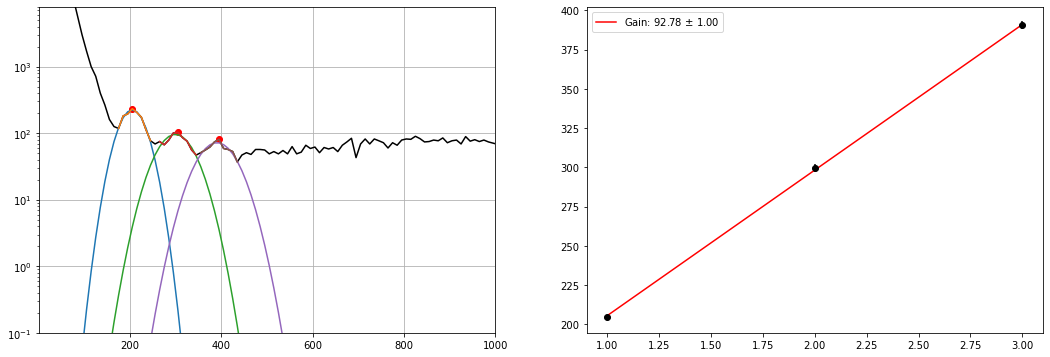

Working on file /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step10/mca_keith_31.40OV_310_0.h5
Guess:  [220, 195.03571428571428, 10]
Params:  [225.21265328 200.54117956  29.13508599]
Guess:  [117, 305.0558608058608, 10]
Params:  [113.16938034 298.54012555  33.84131611]
Guess:  [81, 375.06868131868134, 10]
Params:  [ 68.22669105 380.11831036  51.86697264]


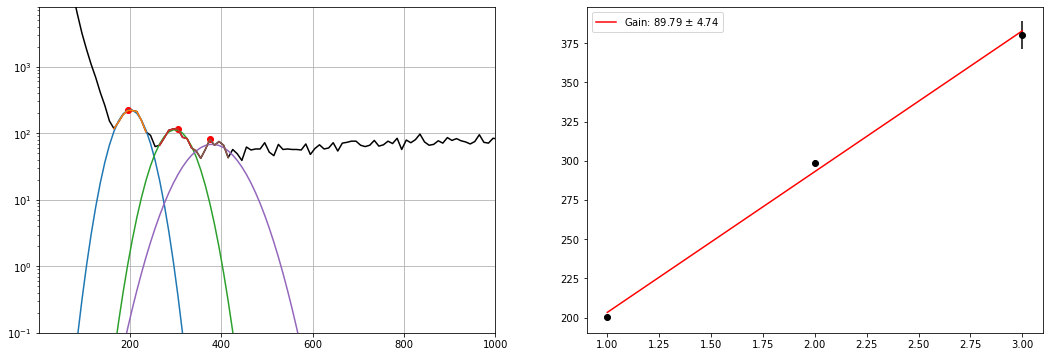

In [10]:
data_POS_FIELD = {'source':{}, 405.0:{}, 310.0:{}}

for file_type, file_list in files_10.items():
    # creating the data fields in the dict
    data_POS_FIELD[file_type]['pe_data'] = []
    data_POS_FIELD[file_type]['counts'] = []
    data_POS_FIELD[file_type]['gain'] = np.empty(len(file_list))
    data_POS_FIELD[file_type]['gain_err'] = np.empty(len(file_list))
    data_POS_FIELD[file_type]['dc_offset'] = np.empty(len(file_list))
    for i, file in enumerate(file_list):
        pe, counts, gain, gain_err, dc_offset = plot_fit_gain_dc(file, 25, 10, 10)
        data_POS_FIELD[file_type]['pe_data'].append(pe)
        data_POS_FIELD[file_type]['counts'].append(counts)
        data_POS_FIELD[file_type]['gain'][i] = gain
        data_POS_FIELD[file_type]['gain_err'][i] = gain_err
        data_POS_FIELD[file_type]['dc_offset'][i] = dc_offset
    # converting all the lists to arrays 
    data_POS_FIELD[file_type]['pe_data'] = np.array(data_POS_FIELD[file_type]['pe_data'])
    data_POS_FIELD[file_type]['counts'] = np.array(data_POS_FIELD[file_type]['counts'])

-1.1022387428742475
-1.2211971881411505
-1.1402481092503292


<Figure size 648x432 with 0 Axes>

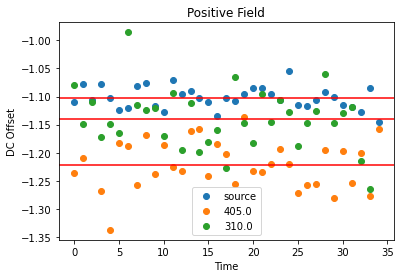

In [12]:
plt.figure(figsize = (9, 6))
# plotting the gain over time

# getting the "time"
time_POS_FIELD = {}
for key in files_10:
    time_POS_FIELD[key] = np.arange(0, len(files_10[key]))
plt.figure(figsize=(6,4))
for key in data_POS_FIELD:
    data_POS_FIELD[key]['dc_offset'] = np.asarray(data_POS_FIELD[key]['dc_offset'])
    data_POS_FIELD[key]['dc_offset'][data_POS_FIELD[key]['dc_offset'] < -5] = np.nan # setting any outliers to nan
    masked_data = np.ma.masked_array(data_POS_FIELD[key]['dc_offset'], np.isnan(data_POS_FIELD[key]['dc_offset'])) # creating a masked array to ignore the nan when tkaing the average dc offset
    dc_offset_mean = np.ma.average(masked_data)
    data_POS_FIELD[key]['mean_dc_offset'] = dc_offset_mean
    plt.scatter(time_POS_FIELD[key], data_POS_FIELD[key]['dc_offset'], marker='o', label= str(key))
    plt.axhline(y=dc_offset_mean, color='r')
    print(dc_offset_mean)

plt.ylabel('DC Offset')
plt.xlabel('Time')
plt.title('Positive Field')
# plt.ylim(-1.4, -1)
# plt.grid()
plt.legend(loc='best')
# plt.savefig('NO_FIELD_gain_comparison.pdf')
plt.show()